## Installazione Pacchetti

Installazione di tutte le librerie necessarie per il progetto.

In [ ]:
# Install required packages
# Nota: In VS Code, assicurati di aver selezionato un ambiente Python con Jupyter
import sys
import subprocess

packages = [
    'transformers>=4.30.0',
    'datasets',
    'scikit-learn',
    'seaborn',
    'matplotlib',
    'tqdm',
    'accelerate',
    'sentencepiece',
    'torch',
    'huggingface-hub'
]

print("Installazione pacchetti...")
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    except:
        print(f"Errore nell'installazione di {package}")

print("All packages installed successfully!")

📦 Installazione pacchetti...
✅ All packages installed successfully!


## Autenticazione HuggingFace

Configurazione del token HuggingFace.
- **VS Code**: Imposta la variabile d'ambiente `HF_TOKEN`
- **Google Colab**: Usa Colab Secrets

In [1]:
from huggingface_hub import login
import os

# Get HuggingFace token from environment variable
# Per impostare il token: set HF_TOKEN=your_token_here (Windows PowerShell)
# Oppure su Google Colab: userdata.get('HF_TOKEN')
try:
    # Prova prima con variabile d'ambiente (per VS Code)
    HF_TOKEN = os.getenv('HF_TOKEN')

    if HF_TOKEN is None:
        # Fallback per Google Colab
        try:
            from google.colab import userdata
            HF_TOKEN = userdata.get('HF_TOKEN')
        except:
            print("HF_TOKEN non trovato. Puoi impostarlo con:")
            print("  - Windows: $env:HF_TOKEN='your_token'")
            print("  - Linux/Mac: export HF_TOKEN='your_token'")
            print("  - Google Colab: Aggiungi HF_TOKEN ai Secrets")
            HF_TOKEN = None

    if HF_TOKEN:
        # Login to HuggingFace
        login(token=HF_TOKEN)
        print("Successfully authenticated with HuggingFace!")
    else:
        print("Continuando senza autenticazione HuggingFace.")
        print("  Alcuni modelli potrebbero non essere accessibili.")

except Exception as e:
    print(f"Errore durante l'autenticazione: {e}")
    print("  Continuando senza autenticazione HuggingFace.")

Successfully authenticated with HuggingFace!


## Configurazione Dataset

Configurazione degli URL per il caricamento dei dati da GitHub.

In [2]:
# Configuration
TRACK = "track_a"
SUBTASK = "3"  # Subtask 3 per Quadruplet Extraction (DimASQP)
LANGUAGE = "eng"  # Lingua: eng, jpn, rus, tat, ukr, zho
DOMAIN = "restaurant"  # Dominio: restaurant, laptop, hotel

# Build GitHub URLs
BASE_URL = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset"
TRAIN_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_train_alltasks.jsonl"

# Display configuration
print("="*60)
print("CONFIGURAZIONE DATASET")
print("="*60)
print(f"Track:     {TRACK}")
print(f"Subtask:   {SUBTASK} (Quadruplet Extraction - DimASQP)")
print(f"Language:  {LANGUAGE}")
print(f"Domain:    {DOMAIN}")
print(f"\nTrain URL: {TRAIN_URL}")
print("="*60)

CONFIGURAZIONE DATASET
Track:     track_a
Subtask:   3 (Quadruplet Extraction - DimASQP)
Language:  eng
Domain:    restaurant

Train URL: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_3/eng/eng_restaurant_train_alltasks.jsonl


# DimABSA Track A - Subtask 3: Dimensional Aspect Sentiment Quad Prediction (DimASQP)

## Obiettivo
Dato un testo, estrarre tutti i **quadruplet (Aspect, Category, Opinion, VA)** dove:
- **Aspect**: termine che indica l'aspetto target (può essere NULL)
- **Category**: categoria dell'aspetto nel formato ENTITY#ATTRIBUTE (NON è mai NULL, sempre UPPERCASE)
- **Opinion**: termine che esprime il sentiment (può essere NULL)
- **VA**: punteggio Valence-Arousal (V#A) con valori da 1.00 a 9.00

## Pipeline
1. **Estrazione Aspect/Category/Opinion**: Uso di LLM (LLAMA) con prompt engineering
2. **Predizione VA**: Modello encoder (BERT multilingua) per predire i valori continui

---

## 1. Setup e Import Librerie

In [3]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel
)

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


## 2. Analisi del Dataset

In [4]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Carica dati JSONL da un URL GitHub.

    Args:
        url: URL del file JSONL

    Returns:
        Lista di dizionari
    """
    import urllib.request

    try:
        print(f"⏳ Caricamento da {url.split('/')[-1]}...")
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            items = [json.loads(line) for line in data.strip().split('\n') if line.strip()]
        print(f"✓ Caricati {len(items)} esempi")
        return items
    except Exception as e:
        print(f"❌ Errore nel caricamento da {url}: {e}")
        raise

# Caricamento dati
train_data = load_jsonl_from_url(TRAIN_URL)
print(f"\n{'='*60}")
print(f"DATASET CARICATO")
print(f"{'='*60}")
print(f"Numero di esempi nel training set: {len(train_data)}")
print(f"\nEsempio di dato:")
print(json.dumps(train_data[0], indent=2))


⏳ Caricamento da eng_restaurant_train_alltasks.jsonl...
✓ Caricati 2284 esempi

DATASET CARICATO
Numero di esempi nel training set: 2284

Esempio di dato:
{
  "ID": "rest16_quad_dev_1",
  "Text": "ca n ' t wait wait for my next visit .",
  "Quadruplet": [
    {
      "Aspect": "NULL",
      "Opinion": "NULL",
      "Category": "RESTAURANT#GENERAL",
      "VA": "6.75#6.38"
    }
  ]
}


In [5]:
# Analisi statistica del dataset
def analyze_dataset(data: List[Dict]) -> Dict:
    """Analizza il dataset e restituisce statistiche."""
    stats = {
        'valence_values': [],
        'arousal_values': [],
        'text_lengths': [],
        'num_triplets': [],
        'aspects': [],
        'opinions': [],
        'categories': [],
        'null_aspect_count': 0,
        'null_opinion_count': 0,
        'null_both_count': 0
    }

    for item in data:
        text_length = len(item['Text'].split())
        stats['text_lengths'].append(text_length)

        quadruplets = item.get('Quadruplet', item.get('Triplet', []))
        stats['num_triplets'].append(len(quadruplets))

        for quad in quadruplets:
            va = quad['VA'].split('#')
            stats['valence_values'].append(float(va[0]))
            stats['arousal_values'].append(float(va[1]))

            # Analisi Aspect, Opinion, Category
            aspect = quad['Aspect']
            opinion = quad['Opinion']
            category = quad.get('Category', 'N/A')

            stats['aspects'].append(aspect)
            stats['opinions'].append(opinion)
            stats['categories'].append(category)

            # Conta NULL
            if aspect == 'NULL' and opinion == 'NULL':
                stats['null_both_count'] += 1
            elif aspect == 'NULL':
                stats['null_aspect_count'] += 1
            elif opinion == 'NULL':
                stats['null_opinion_count'] += 1

    return stats

# Calcola statistiche
train_stats = analyze_dataset(train_data)

print(f"\n{'='*60}")
print("STATISTICHE DATASET")
print(f"{'='*60}")
print(f"Numero totale di quadruplet: {len(train_stats['valence_values'])}")
print(f"\nValence:")
print(f"  - Media: {np.mean(train_stats['valence_values']):.2f}")
print(f"  - Std: {np.std(train_stats['valence_values']):.2f}")
print(f"  - Min: {np.min(train_stats['valence_values']):.2f}")
print(f"  - Max: {np.max(train_stats['valence_values']):.2f}")
print(f"\nArousal:")
print(f"  - Media: {np.mean(train_stats['arousal_values']):.2f}")
print(f"  - Std: {np.std(train_stats['arousal_values']):.2f}")
print(f"  - Min: {np.min(train_stats['arousal_values']):.2f}")
print(f"  - Max: {np.max(train_stats['arousal_values']):.2f}")
print(f"\nLunghezza testi:")
print(f"  - Media: {np.mean(train_stats['text_lengths']):.1f} parole")
print(f"  - Min: {np.min(train_stats['text_lengths'])} parole")
print(f"  - Max: {np.max(train_stats['text_lengths'])} parole")
print(f"\nNull Values:")
print(f"  - Aspect NULL (Opinion presente): {train_stats['null_aspect_count']}")
print(f"  - Opinion NULL (Aspect presente): {train_stats['null_opinion_count']}")
print(f"  - Entrambi NULL: {train_stats['null_both_count']}")
print(f"  - Categorie uniche: {len(set(train_stats['categories']))}")
print(f"{'='*60}")


STATISTICHE DATASET
Numero totale di quadruplet: 3659

Valence:
  - Media: 6.22
  - Std: 1.83
  - Min: 1.00
  - Max: 9.00

Arousal:
  - Media: 6.84
  - Std: 1.13
  - Min: 3.83
  - Max: 9.00

Lunghezza testi:
  - Media: 15.1 parole
  - Min: 1 parole
  - Max: 84 parole

Null Values:
  - Aspect NULL (Opinion presente): 530
  - Opinion NULL (Aspect presente): 349
  - Entrambi NULL: 350
  - Categorie uniche: 14


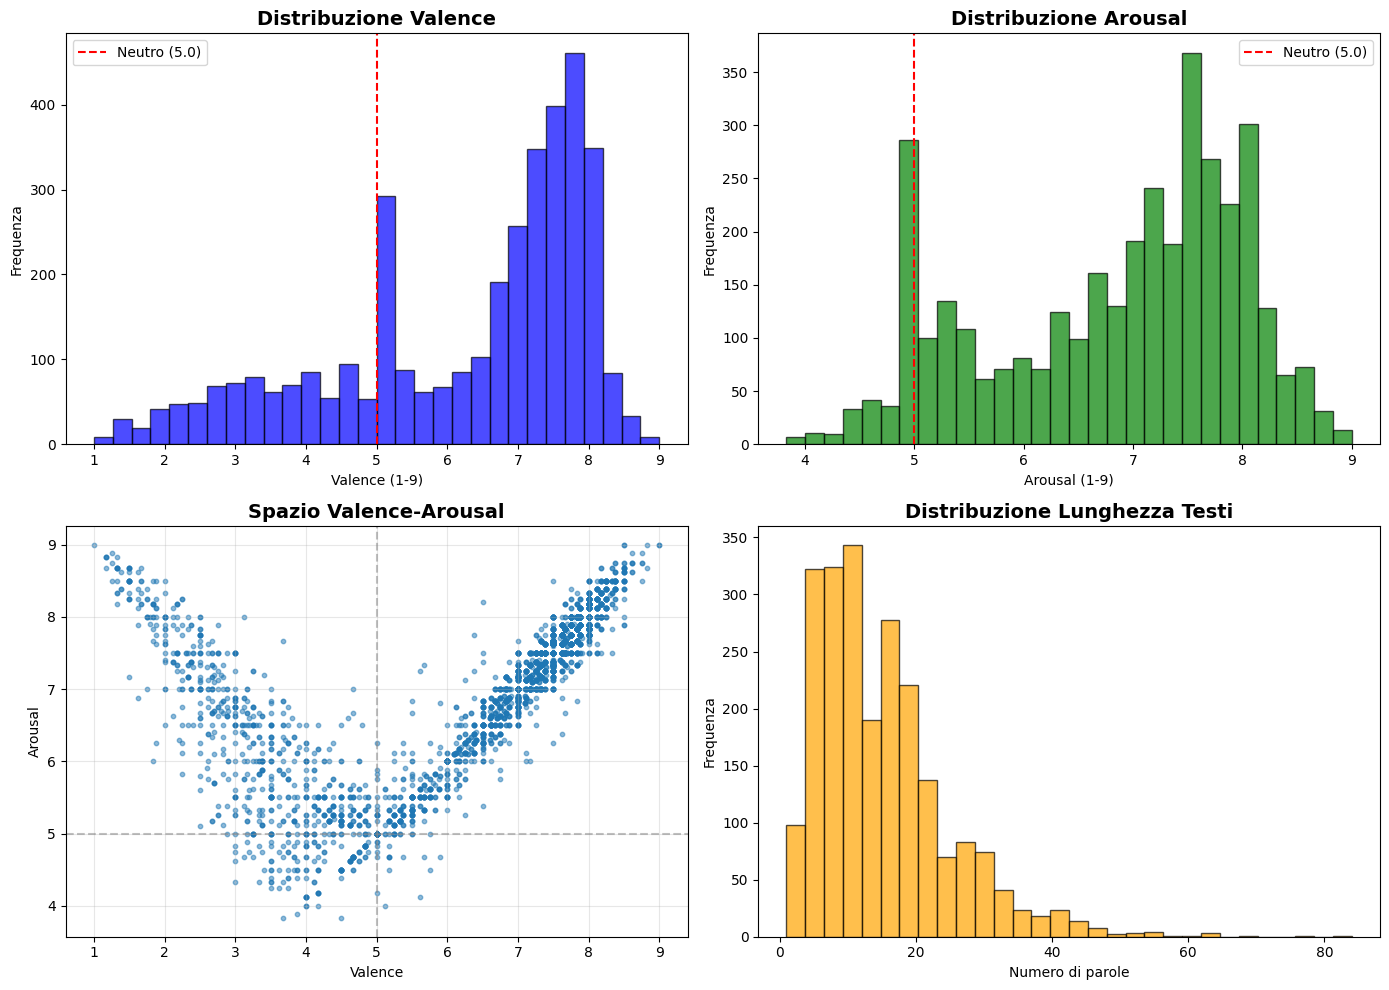

In [6]:
# Visualizzazioni
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribuzione Valence
axes[0, 0].hist(train_stats['valence_values'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribuzione Valence', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Valence (1-9)')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 0].legend()

# Distribuzione Arousal
axes[0, 1].hist(train_stats['arousal_values'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribuzione Arousal', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Arousal (1-9)')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 1].legend()

# Scatter plot VA
axes[1, 0].scatter(train_stats['valence_values'], train_stats['arousal_values'],
                   alpha=0.5, s=10)
axes[1, 0].set_title('Spazio Valence-Arousal', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Valence')
axes[1, 0].set_ylabel('Arousal')
axes[1, 0].axhline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Distribuzione lunghezza testi
axes[1, 1].hist(train_stats['text_lengths'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribuzione Lunghezza Testi', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Numero di parole')
axes[1, 1].set_ylabel('Frequenza')

plt.tight_layout()
plt.show()

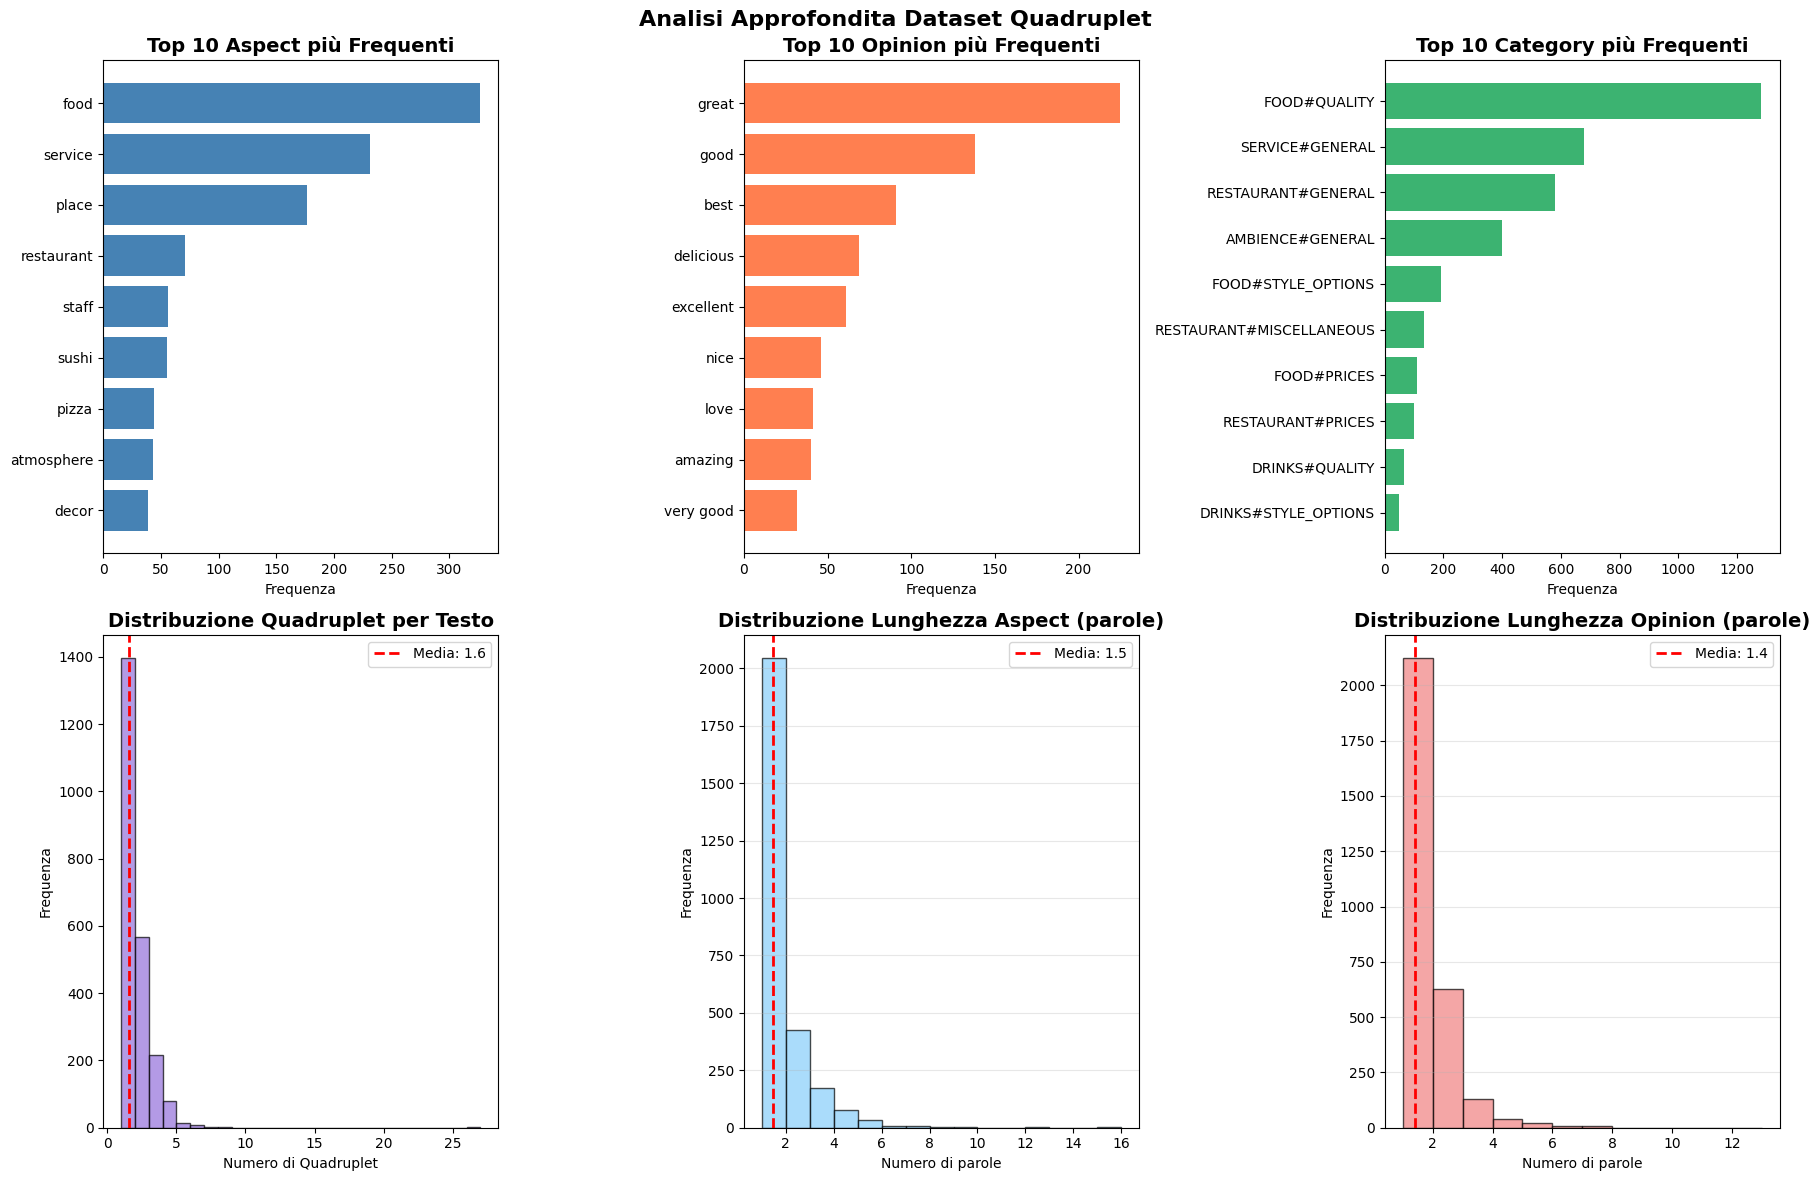


Insights:
  - Aspect più comune: 'food' (326 occorrenze)
  - Opinion più comune: 'great' (225 occorrenze)
  - Category più comune: 'FOOD#QUALITY' (1282 occorrenze)
  - Lunghezza media Aspect: 1.46 parole
  - Lunghezza media Opinion: 1.40 parole


In [7]:
# Visualizzazioni avanzate per EDA Subtask 3

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analisi Approfondita Dataset Quadruplet', fontsize=16, fontweight='bold')

# 1. Top 10 Aspect più frequenti
aspect_counts = {}
for item in train_data:
    for quad in item['Quadruplet']:
        aspect = quad['Aspect']
        aspect_counts[aspect] = aspect_counts.get(aspect, 0) + 1

# Ordina per frequenza
aspects_sorted = sorted(aspect_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_aspects = [(a, c) for a, c in aspects_sorted if a != 'NULL'][:10]

axes[0, 0].barh([a[0][:20] for a in top_aspects], [a[1] for a in top_aspects], color='steelblue')
axes[0, 0].set_title('Top 10 Aspect più Frequenti', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Frequenza')
axes[0, 0].invert_yaxis()

# 2. Top 10 Opinion più frequenti
opinion_counts = {}
for item in train_data:
    for quad in item['Quadruplet']:
        opinion = quad['Opinion']
        opinion_counts[opinion] = opinion_counts.get(opinion, 0) + 1

opinions_sorted = sorted(opinion_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_opinions = [(o, c) for o, c in opinions_sorted if o != 'NULL'][:10]

axes[0, 1].barh([o[0][:20] for o in top_opinions], [o[1] for o in top_opinions], color='coral')
axes[0, 1].set_title('Top 10 Opinion più Frequenti', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Frequenza')
axes[0, 1].invert_yaxis()

# 3. Distribuzione Category
category_counts = {}
for item in train_data:
    for quad in item['Quadruplet']:
        category = quad['Category']
        category_counts[category] = category_counts.get(category, 0) + 1

categories_sorted = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:10]

axes[0, 2].barh([c[0][:25] for c in categories_sorted], [c[1] for c in categories_sorted], color='mediumseagreen')
axes[0, 2].set_title('Top 10 Category più Frequenti', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Frequenza')
axes[0, 2].invert_yaxis()

# 4. Distribuzione numero di quadruplet per testo
quads_per_text = [len(item['Quadruplet']) for item in train_data]
axes[1, 0].hist(quads_per_text, bins=range(1, max(quads_per_text)+2), color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribuzione Quadruplet per Testo', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Numero di Quadruplet')
axes[1, 0].set_ylabel('Frequenza')
axes[1, 0].axvline(np.mean(quads_per_text), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(quads_per_text):.1f}')
axes[1, 0].legend()

# 5. Distribuzione lunghezza Aspect (in parole)
aspect_lengths = [len(quad['Aspect'].split()) for item in train_data for quad in item['Quadruplet'] if quad['Aspect'] != 'NULL']
axes[1, 1].hist(aspect_lengths, bins=range(1, max(aspect_lengths)+2), color='lightskyblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribuzione Lunghezza Aspect (parole)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Numero di parole')
axes[1, 1].set_ylabel('Frequenza')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].axvline(np.mean(aspect_lengths), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(aspect_lengths):.1f}')
axes[1, 1].legend()

# 6. Distribuzione lunghezza Opinion (in parole)
opinion_lengths = [len(quad['Opinion'].split()) for item in train_data for quad in item['Quadruplet'] if quad['Opinion'] != 'NULL']
axes[1, 2].hist(opinion_lengths, bins=range(1, max(opinion_lengths)+2), color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Distribuzione Lunghezza Opinion (parole)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Numero di parole')
axes[1, 2].set_ylabel('Frequenza')
axes[1, 2].grid(axis='y', alpha=0.3)
axes[1, 2].axvline(np.mean(opinion_lengths), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(opinion_lengths):.1f}')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print(f"\nInsights:")
print(f"  - Aspect più comune: '{top_aspects[0][0]}' ({top_aspects[0][1]} occorrenze)")
print(f"  - Opinion più comune: '{top_opinions[0][0]}' ({top_opinions[0][1]} occorrenze)")
print(f"  - Category più comune: '{categories_sorted[0][0]}' ({categories_sorted[0][1]} occorrenze)")
print(f"  - Lunghezza media Aspect: {np.mean(aspect_lengths):.2f} parole")
print(f"  - Lunghezza media Opinion: {np.mean(opinion_lengths):.2f} parole")

In [8]:
# Per Subtask 3, i dati sono già in formato Quadruplet, non serve conversione
print(f"Dati in formato Quadruplet per Subtask 3")
print(f"\nEsempio di Quadruplet dal dataset:")
print(json.dumps(train_data[2], indent=2))

Dati in formato Quadruplet per Subtask 3

Esempio di Quadruplet dal dataset:
{
  "ID": "rest16_quad_dev_3",
  "Text": "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !",
  "Quadruplet": [
    {
      "Aspect": "spicy tuna roll",
      "Opinion": "unusually good",
      "Category": "FOOD#QUALITY",
      "VA": "7.50#7.62"
    },
    {
      "Aspect": "rock shrimp tempura",
      "Opinion": "awesome",
      "Category": "FOOD#QUALITY",
      "VA": "8.25#8.38"
    }
  ]
}


## Gestione Split Dataset: LLM Extraction vs VA Training

**Obiettivo**: Separare chiaramente:
- **LLM Extraction Split**: Per testare LLAMA su train/val/test mantenendo consistenza
- **VA Training Dataset**: Usa sempre gli stessi ID record originali per training BERT

Questo permette di:
1. Testare l'estrazione di LLAMA su subset diversi (train/val/test)
2. Mantenere coerenza negli ID dei record quando si traina il modello VA
3. Garantire riproducibilità e confrontabilità dei risultati

In [9]:
def create_dataset_splits(data: List[Dict],
                         train_ratio: float = 0.7,
                         val_ratio: float = 0.15,
                         test_ratio: float = 0.15,
                         seed: int = 42):
    """
    Crea split consistenti per train/val/test mantenendo gli ID originali.

    Args:
        data: Dataset completo
        train_ratio: Percentuale per training set
        val_ratio: Percentuale per validation set
        test_ratio: Percentuale per test set
        seed: Random seed per riproducibilità

    Returns:
        Tuple (train_data, val_data, test_data) con ID originali preservati
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Le proporzioni devono sommare a 1.0"

    # Shuffle con seed fisso per riproducibilità
    np.random.seed(seed)
    indices = np.random.permutation(len(data))

    # Calcola dimensioni degli split
    n_train = int(len(data) * train_ratio)
    n_val = int(len(data) * val_ratio)

    # Split degli indici
    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]

    # Crea i subset mantenendo gli ID originali
    train_split = [data[i] for i in train_indices]
    val_split = [data[i] for i in val_indices]
    test_split = [data[i] for i in test_indices]

    # Salva gli indici per riferimento futuro
    split_info = {
        'train_indices': train_indices.tolist(),
        'val_indices': val_indices.tolist(),
        'test_indices': test_indices.tolist(),
        'train_ids': [item['ID'] for item in train_split],
        'val_ids': [item['ID'] for item in val_split],
        'test_ids': [item['ID'] for item in test_split]
    }

    return train_split, val_split, test_split, split_info


# Crea gli split
print("\n" + "="*80)
print("📊 CREAZIONE SPLIT DATASET (Train/Val/Test)")
print("="*80)

train_split_data, val_split_data, test_split_data, split_info = create_dataset_splits(
    data=train_data,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=SEED
)

print(f"\n✅ Split creati con successo:")
print(f"  - Training set:   {len(train_split_data)} esempi ({len(train_split_data)/len(train_data)*100:.1f}%)")
print(f"  - Validation set: {len(val_split_data)} esempi ({len(val_split_data)/len(train_data)*100:.1f}%)")
print(f"  - Test set:       {len(test_split_data)} esempi ({len(test_split_data)/len(train_data)*100:.1f}%)")
print(f"\n📋 ID preservati:")
print(f"  - Train IDs: {train_split_data[0]['ID']}, {train_split_data[1]['ID']}, ...")
print(f"  - Val IDs:   {val_split_data[0]['ID']}, {val_split_data[1]['ID']}, ...")
print(f"  - Test IDs:  {test_split_data[0]['ID']}, {test_split_data[1]['ID']}, ...")
print("="*80)


📊 CREAZIONE SPLIT DATASET (Train/Val/Test)

✅ Split creati con successo:
  - Training set:   1598 esempi (70.0%)
  - Validation set: 342 esempi (15.0%)
  - Test set:       344 esempi (15.1%)

📋 ID preservati:
  - Train IDs: rest16_quad_test_213, rest16_quad_train_1432, ...
  - Val IDs:   rest16_quad_dev_80, rest16_quad_train_419, ...
  - Test IDs:  rest16_quad_train_413, rest16_quad_test_300, ...


In [10]:
class AspectOpinionCategoryExtractor:
    """Estrattore di Aspect, Opinion e Category usando LLM per Subtask 3."""

    def __init__(self, model_name: str = "meta-llama/Llama-3.2-3B-Instruct"):
        """
        Inizializza l'estrattore.

        Args:
            model_name: Nome del modello HuggingFace da utilizzare
        """
        print(f"Caricamento del modello {model_name}...")

        # Carica tokenizer e modello (senza quantizzazione)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,  # Usa float16 per efficienza
            device_map="auto",
            trust_remote_code=True
        )

        # Set pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print("Modello caricato con successo!")

    def create_prompt(self, text: str) -> str:
        """Crea il prompt few-shot per l'estrazione di Aspect, Opinion e Category."""
        prompt = f"""### TASK
You are an aspect-category-opinion extraction system for restaurant reviews. Extract triplets and return ONLY a valid JSON array.

### RULES:
1. ASPECT = target entity/attribute. Use "NULL" if implicit or not mentioned.
2. CATEGORY = Entity#Attribute in UPPERCASE (e.g., "FOOD#QUALITY", "SERVICE#GENERAL"). NEVER NULL - always predict a category.
3. OPINION = sentiment word short phrase taken from the input text (e.g., "delicious", "terrible"). Use "NULL" if implicit or not expressed.
4. Return ONLY the JSON array, nothing else.

VALID CATEGORIES for Restaurant domain:
- Entities: RESTAURANT, FOOD, DRINKS, AMBIENCE, SERVICE, LOCATION
- Attributes: GENERAL, PRICES, QUALITY, STYLE_OPTIONS, MISCELLANEOUS
- Format: ENTITY#ATTRIBUTE (e.g., FOOD#QUALITY, SERVICE#GENERAL, RESTAURANT#PRICES)

### EXAMPLES:

Text: "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !"
[{{"aspect": "spicy tuna roll", "category": "FOOD#QUALITY", "opinion": "unusually good"}}, {{"aspect": "rock shrimp tempura", "category": "FOOD#QUALITY", "opinion": "awesome"}}]

Text: "we love th pink pony ."
[{{"aspect": "pink pony", "category": "RESTAURANT#GENERAL", "opinion": "love"}}]

Text: "the hanger steak was like rubber and the tuna was flavorless not to mention it tasted like it had just been thawed ."
[{{"Aspect": "hanger steak", "Opinion": "rubber", "Category": "FOOD#QUALITY", "VA": "2.40#6.50"}}, {{"Aspect": "tuna", "Opinion": "flavorless", "Category": "FOOD#QUALITY", "VA": "2.20#6.30"}}]

Text: "this place has got to be the best japanese restaurant in the new york area ."
[{{"aspect": "place", "category": "RESTAURANT#GENERAL", "opinion": "best"}}]

Text: "i tend to judge a sushi restaurant by its sea urchin , which was heavenly at sushi rose ."
[{{"aspect": "sea urchin", "category": "FOOD#QUALITY", "opinion": "heavenly"}}]

Text: "also , specify if you like your food spicy - its rather bland if you do n ' t ."
[{{"aspect": "food", "category": "FOOD#QUALITY", "opinion": "rather bland"}}]

Text: "their sake list was extensive , but we were looking for purple haze , which was n ' t listed but made for us upon request !"
[{{"aspect": "sake list", "category": "DRINKS#STYLE_OPTIONS", "opinion": "extensive"}}, {{"aspect": "NULL", "category": "SERVICE#GENERAL", "opinion": "NULL"}}]

Text: "the food here is rather good , but only if you like to wait for it ."
[{{"aspect": "food", "category": "FOOD#QUALITY", "opinion": "rather good"}}, {{"aspect": "NULL", "category": "SERVICE#GENERAL", "opinion": "NULL"}}]

Text: "the ambience is pretty and nice for conversation , so a casual lunch here would probably be best ."
[{{"aspect": "ambience", "category": "AMBIENCE#GENERAL", "opinion": "pretty"}}, {{"aspect": "ambience", "category": "AMBIENCE#GENERAL", "opinion": "nice"}}, {{"aspect": "NULL", "category": "RESTAURANT#MISCELLANEOUS", "opinion": "best"}}]

Text: "at $ 120 for two people , however , this in no way represents value , unless you ' re looking to pay by the hour for passive - aggressive torture ."
[{{"Aspect": "NULL", "Opinion": "NULL", "Category": "RESTAURANT#PRICES", "VA": "3.00#6.75"}}, {{"Aspect": "NULL", "Opinion": "NULL", "Category": "RESTAURANT#GENERAL", "VA": "3.25#6.50"}}, {{"Aspect": "NULL", "Opinion": "passive - aggressive", "Category": "SERVICE#GENERAL", "VA": "3.25#6.75"}}]

### INPUT
Text: "{text}"

### OUTPUT
"""
        return prompt

    def extract(self, text: str, max_new_tokens: int = 80) -> List[Dict[str, str]]:
        """Estrae aspect, category e opinion dal testo con parsing JSON robusto."""
        prompt = self.create_prompt(text)

        # Tokenizza
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Genera
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Decodifica SOLO la parte generata (non il prompt)
        input_length = inputs["attention_mask"][0].sum().item()
        generated_ids = outputs[0][input_length:]
        response = self.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # Usa helper per parsing
        return self._parse_json_response(response)

    def _parse_json_response(self, response: str) -> List[Dict[str, str]]:
        import json
        import re

        try:
            # Step 1: rimuovi markdown
            response = response.replace('```json', '').replace('```', '').strip()

            # Step 2: trova TUTTI gli array JSON (non greedy)
            candidates = re.findall(r'\[[\s\S]*?\]', response)

            for json_str in candidates:
                try:
                    result = json.loads(json_str)

                    # accettiamo solo liste non vuote
                    if isinstance(result, list) and len(result) > 0:
                        normalized = []
                        seen = set()  # Per tracciare i duplicati

                        for item in result:
                            if not isinstance(item, dict):
                                continue

                            aspect = str(item.get('aspect', item.get('Aspect', 'NULL'))).strip()
                            category = str(item.get('category', item.get('Category', 'RESTAURANT#GENERAL'))).strip().upper()
                            opinion = str(item.get('opinion', item.get('Opinion', 'NULL'))).strip()

                            if not aspect:
                                aspect = 'NULL'
                            if not opinion:
                                opinion = 'NULL'
                            if not category or category == 'NULL':
                                category = 'RESTAURANT#GENERAL'

                            # Crea una tupla per identificare duplicati (case-insensitive per aspect e opinion)
                            triplet_key = (aspect.lower(), category, opinion.lower())

                            # Aggiungi solo se non è un duplicato
                            if triplet_key not in seen:
                                seen.add(triplet_key)
                                normalized.append({
                                    'Aspect': aspect,
                                    'Category': category,
                                    'Opinion': opinion
                                })

                        if normalized:
                            return normalized

                except json.JSONDecodeError:
                    continue

            # fallback
            return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

        except Exception:
            return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

    def extract_batch(self, texts: List[str], max_new_tokens: int = 200) -> List[List[Dict[str, str]]]:
        """
        Estrae aspect, category e opinion per un batch di testi (PARALLELO).

        Args:
            texts: Lista di testi da processare
            max_new_tokens: Numero massimo di token da generare

        Returns:
            Lista di liste di dict con Aspect, Category, Opinion
        """
        # Crea prompts per tutti i testi
        prompts = [self.create_prompt(text) for text in texts]

        # Tokenizza tutti i prompts insieme (batch processing)
        inputs = self.tokenizer(
            prompts,
            return_tensors="pt",
            truncation=True,
            max_length=4096,
            padding=True  # Importante per batch processing
        )
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Genera per tutto il batch
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Decodifica e parse per ogni output nel batch
        all_results = []
        for i, output in enumerate(outputs):
            # Decodifica SOLO la parte generata (non il prompt)
            input_length = inputs["attention_mask"][i].sum().item()
            generated_ids = output[input_length:]
            response = self.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

            # Usa helper per parsing
            parsed = self._parse_json_response(response)
            all_results.append(parsed)

        return all_results

print("\nNOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.")
print("Assicurati di aver configurato il token HuggingFace nella cella iniziale.")
print("\n⚡ Metodo extract_batch() aggiunto per processing parallelo!")


NOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.
Assicurati di aver configurato il token HuggingFace nella cella iniziale.

⚡ Metodo extract_batch() aggiunto per processing parallelo!


## Debug: Output Grezzo del Modello LLAMA

Visualizziamo l'output effettivo del modello LLAMA prima del parsing JSON per capire cosa sta generando.

In [11]:

# Test con alcuni esempi dal training set
print("\nTEST DELL'OUTPUT GREZZO DEL MODELLO LLAMA\n")

# Crea l'extractor (se non già creato)
try:
    # Verifica se llm_extractor esiste già
    llm_extractora
    print("LLM Extractor già caricato\n")
except NameError:
    try:
        del llm_extractor
    except NameError:
        pass

    torch.cuda.empty_cache()
    print("Caricamento LLM Extractor...\n")
    llm_extractor = AspectOpinionCategoryExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")
    print("LLM Extractor caricato\n")

# Test su 3 esempi diversi
test_examples = [
    "but the staff was so horrible to us .",
    "the menu is very limited - i think we counted 4 or 5 entrees .",
    "i ' m still mad that i had to pay for lousy food ."
]

for i, text in enumerate(test_examples, 1):
    print(f"\n{'#'*80}")
    print(f"ESEMPIO {i}/{len(test_examples)}")
    print(f"{'#'*80}\n")
    print(llm_extractor.extract(text))
    print("\n")



TEST DELL'OUTPUT GREZZO DEL MODELLO LLAMA

Caricamento LLM Extractor...

Caricamento del modello meta-llama/Llama-3.2-3B-Instruct...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Modello caricato con successo!
LLM Extractor caricato


################################################################################
ESEMPIO 1/3
################################################################################

[{'Aspect': 'staff', 'Category': 'SERVICE#GENERAL', 'Opinion': 'horrible'}]



################################################################################
ESEMPIO 2/3
################################################################################

[{'Aspect': 'menu', 'Category': 'FOOD#GENERAL', 'Opinion': 'limited'}, {'Aspect': 'entrees', 'Category': 'FOOD#GENERAL', 'Opinion': '4 or 5'}]



################################################################################
ESEMPIO 3/3
################################################################################

[{'Aspect': 'lousy food', 'Category': 'FOOD#QUALITY', 'Opinion': 'mad'}]




In [12]:
# Test con alcuni esempi dal training set
print("\nTEST DELL'OUTPUT GREZZO DEL MODELLO LLAMA VERSIONE BATCH\n")

# Crea l'extractor (se non già creato)
try:
    # Verifica se llm_extractor esiste già
    llm_extractor
    print("LLM Extractor già caricato\n")
except NameError:
    print("Caricamento LLM Extractor...\n")
    llm_extractor = AspectOpinionCategoryExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")
    print("LLM Extractor caricato\n")

# Test su 3 esempi diversi
texts = [
    "ca n ' t wait wait for my next visit .",
    "Great atmosphere and amazing cocktails!",
    "It was horrible."
]

print(llm_extractor.extract_batch(texts))


TEST DELL'OUTPUT GREZZO DEL MODELLO LLAMA VERSIONE BATCH

LLM Extractor già caricato

[[{'Aspect': 'NULL', 'Category': 'RESTAURANT#MISCELLANEOAS', 'Opinion': 'NULL'}], [{'Aspect': 'atmosphere', 'Category': 'AMBIENCE#GENERAL', 'Opinion': 'Great'}, {'Aspect': 'cocktails', 'Category': 'DRINKS#STYLE_OPTIONS', 'Opinion': 'amazing'}], [{'Aspect': 'NULL', 'Category': 'FOOD#QUALITY', 'Opinion': 'NULL'}]]


## Valutazione Estrazione Aspect, Category, Opinion

Valutiamo le prestazioni dell'LLM nell'estrazione delle triple (Aspect, Category, Opinion) confrontandole con il ground truth del training set.

In [13]:
def evaluate_extraction_performance(extractor, dataset: List[Dict], num_samples: int = 100, batch_size: int = 8, split_name: str = "Dataset"):
    """
    Valuta le prestazioni dell'estrazione di (Aspect, Category, Opinion) usando BATCH PROCESSING.

    Calcola metriche basate sul matching categorico:
    - Precision: % di predizioni corrette
    - Recall: % di gold standard trovati
    - F1 Score: media armonica di Precision e Recall

    Args:
        extractor: AspectOpinionCategoryExtractor o OptimizedDimABSAPipeline
        dataset: Lista di esempi dal dataset (train/val/test split con ID preservati)
        num_samples: Numero di esempi da valutare (default 100)
        batch_size: Dimensione del batch per processing parallelo (default 8)
        split_name: Nome dello split (es. "Train", "Validation", "Test") per logging

    Returns:
        Dict con metriche dettagliate
    """
    print(f"\n{'='*80}")
    print(f"📊 VALUTAZIONE ESTRAZIONE ASPECT-CATEGORY-OPINION (BATCH PROCESSING)")
    print(f"📋 Split: {split_name}")
    print(f"{'='*80}")
    print(f"Numero di esempi da valutare: {num_samples}")
    print(f"Batch size: {batch_size}")
    print(f"{'='*80}\n")

    # Limita al numero di campioni richiesto
    sample_data = dataset[:num_samples]

    # Contatori per metriche
    total_tp_cat = 0  # True Positives per match categorico (A,C,O)
    total_pred = 0     # Totale predizioni
    total_gold = 0     # Totale ground truth

    # Contatori per matching parziale
    aspect_only_correct = 0
    category_only_correct = 0
    opinion_only_correct = 0
    aspect_category_correct = 0
    aspect_opinion_correct = 0
    category_opinion_correct = 0

    # Statistiche dettagliate
    exact_matches = 0
    no_matches = 0

    # Per analisi dettagliata
    detailed_results = []

    # Estrai tutti i testi
    texts = [item['Text'] for item in sample_data]
    ids = [item['ID'] for item in sample_data]  # Preserva gli ID

    # Processa in batch usando extract_batch
    print(f"⏳ Estraendo predizioni in batch per split '{split_name}'...")
    all_predictions = []

    # Verifica se l'extractor ha il metodo extract_batch
    if hasattr(extractor, 'extract_batch'):
        # Usa il metodo ottimizzato
        for i in tqdm(range(0, len(texts), batch_size), desc=f"Batch extraction ({split_name})"):
            batch_texts = texts[i:i + batch_size]
            batch_predictions = extractor.extract_batch(batch_texts)
            all_predictions.extend(batch_predictions)
    else:
        # Fallback: usa extract singolo (più lento)
        print("⚠️  Extractor non supporta batch processing, usando metodo singolo (più lento)")
        for text in tqdm(texts, desc=f"Sequential extraction ({split_name})"):
            predicted_triplets = extractor.extract(text)
            all_predictions.append(predicted_triplets)

    print(f"\n⏳ Calcolando metriche per split '{split_name}'...")
    for item, predicted_triplets, record_id in tqdm(zip(sample_data, all_predictions, ids), total=len(sample_data), desc="Valutazione"):
        text = item['Text']
        gold_quadruplets = item['Quadruplet']

        # Normalizza i quadruplet gold per confronto (ignora VA)
        gold_triplets = [
            {
                'Aspect': q['Aspect'].strip().lower(),
                'Category': q['Category'].strip().upper(),
                'Opinion': q['Opinion'].strip().lower()
            }
            for q in gold_quadruplets
        ]

        # Normalizza predizioni
        pred_triplets_normalized = [
            {
                'Aspect': p['Aspect'].strip().lower(),
                'Category': p['Category'].strip().upper(),
                'Opinion': p['Opinion'].strip().lower()
            }
            for p in predicted_triplets
        ]

        total_gold += len(gold_triplets)
        total_pred += len(pred_triplets_normalized)

        # Match categorico completo (A,C,O)
        matched_gold = set()
        matched_pred = set()

        for i, pred in enumerate(pred_triplets_normalized):
            for j, gold in enumerate(gold_triplets):
                if j in matched_gold:
                    continue

                # Match completo (A,C,O)
                if (pred['Aspect'] == gold['Aspect'] and
                    pred['Category'] == gold['Category'] and
                    pred['Opinion'] == gold['Opinion']):
                    total_tp_cat += 1
                    matched_gold.add(j)
                    matched_pred.add(i)
                    exact_matches += 1
                    break

                # Match parziali (per debugging)
                else:
                    aspect_match = pred['Aspect'] == gold['Aspect']
                    category_match = pred['Category'] == gold['Category']
                    opinion_match = pred['Opinion'] == gold['Opinion']

                    if aspect_match and category_match:
                        aspect_category_correct += 1
                    elif aspect_match and opinion_match:
                        aspect_opinion_correct += 1
                    elif category_match and opinion_match:
                        category_opinion_correct += 1
                    elif aspect_match:
                        aspect_only_correct += 1
                    elif category_match:
                        category_only_correct += 1
                    elif opinion_match:
                        opinion_only_correct += 1

        if len(matched_pred) == 0:
            no_matches += 1

        # Salva risultati dettagliati per i primi 5 esempi
        if len(detailed_results) < 5:
            detailed_results.append({
                'id': record_id,  # Preserva ID originale
                'text': text,
                'gold': gold_quadruplets,
                'predicted': predicted_triplets,
                'matches': len(matched_pred)
            })

    # Calcola metriche finali
    precision_cat = total_tp_cat / total_pred if total_pred > 0 else 0
    recall_cat = total_tp_cat / total_gold if total_gold > 0 else 0
    f1_cat = (2 * precision_cat * recall_cat) / (precision_cat + recall_cat) if (precision_cat + recall_cat) > 0 else 0

    # Stampa risultati
    print(f"\n{'='*80}")
    print(f"📈 RISULTATI VALUTAZIONE - {split_name}")
    print(f"{'='*80}")
    print(f"\n🎯 METRICHE PRINCIPALI (Match Categorico Completo A,C,O):")
    print(f"  - Precision: {precision_cat:.4f} ({precision_cat*100:.2f}%)")
    print(f"  - Recall:    {recall_cat:.4f} ({recall_cat*100:.2f}%)")
    print(f"  - F1 Score:  {f1_cat:.4f} ({f1_cat*100:.2f}%)")

    print(f"\n📊 STATISTICHE:")
    print(f"  - Totale predizioni:        {total_pred}")
    print(f"  - Totale ground truth:      {total_gold}")
    print(f"  - True Positives (A,C,O):   {total_tp_cat}")
    print(f"  - False Positives:          {total_pred - total_tp_cat}")
    print(f"  - False Negatives:          {total_gold - total_tp_cat}")
    print(f"  - Match esatti:             {exact_matches}")
    print(f"  - Esempi senza match:       {no_matches}/{num_samples}")

    print(f"\n🔍 MATCH PARZIALI (per debugging):")
    print(f"  - Solo Aspect corretto:          {aspect_only_correct}")
    print(f"  - Solo Category corretto:        {category_only_correct}")
    print(f"  - Solo Opinion corretto:         {opinion_only_correct}")
    print(f"  - Aspect+Category corretti:      {aspect_category_correct}")
    print(f"  - Aspect+Opinion corretti:       {aspect_opinion_correct}")
    print(f"  - Category+Opinion corretti:     {category_opinion_correct}")

    print(f"\n{'='*80}")
    print(f"📋 ESEMPI DETTAGLIATI (primi 5) - {split_name}:")
    print(f"{'='*80}")

    for i, result in enumerate(detailed_results, 1):
        print(f"\n--- Esempio {i} (ID: {result['id']}) ---")
        print(f"Text: {result['text']}")
        print(f"\nGold Truth ({len(result['gold'])} quadruplet):")
        for q in result['gold']:
            print(f"  - A: '{q['Aspect']}', C: '{q['Category']}', O: '{q['Opinion']}'")
        print(f"\nPredizioni ({len(result['predicted'])} triplet):")
        for p in result['predicted']:
            print(f"  - A: '{p['Aspect']}', C: '{p['Category']}', O: '{p['Opinion']}'")
        print(f"Match trovati: {result['matches']}")

    print(f"\n{'='*80}")

    return {
        'split_name': split_name,
        'precision': precision_cat,
        'recall': recall_cat,
        'f1': f1_cat,
        'total_predictions': total_pred,
        'total_gold': total_gold,
        'true_positives': total_tp_cat,
        'exact_matches': exact_matches,
        'no_match_examples': no_matches,
        'partial_matches': {
            'aspect_only': aspect_only_correct,
            'category_only': category_only_correct,
            'opinion_only': opinion_only_correct,
            'aspect_category': aspect_category_correct,
            'aspect_opinion': aspect_opinion_correct,
            'category_opinion': category_opinion_correct
        }
    }


# ========================================================================
# VALUTAZIONE SU SPLIT TRAIN/VAL/TEST CON ID PRESERVATI
# ========================================================================

print("\n🧪 AVVIO VALUTAZIONE DELL'ESTRAZIONE SU SPLIT CON ID PRESERVATI")
print("="*80)
print("Nota: Questa valutazione testa l'estrazione di (Aspect, Category, Opinion)")
print("      su split train/val/test mantenendo gli STESSI ID record usati")
print("      per il training del modello VA (BERT).")
print("      Usa BATCH PROCESSING per velocizzare l'elaborazione!")
print("="*80)

# Crea o verifica l'extractor/pipeline ottimizzata
try:
    # Prova a usare la pipeline ottimizzata se esiste
    optimized_pipeline
    print("✓ OptimizedDimABSAPipeline già disponibile - userò batch processing!\n")
    extractor_to_use = optimized_pipeline
except NameError:
    # Fallback: usa l'extractor singolo
    try:
        llm_extractor
        print("✓ LLM Extractor disponibile\n")
        extractor_to_use = llm_extractor
    except NameError:
        try:
            del llm_extractor
        except NameError:
            pass
        torch.cuda.empty_cache()
        print("⏳ Caricamento LLM Extractor...\n")
        llm_extractor = AspectOpinionCategoryExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")
        llm_extractor.model.eval()
        print("✓ LLM Extractor caricato\n")
        extractor_to_use = llm_extractor

# ========================================================================
# Valuta su TRAIN SET (opzionale, per confronto)
# ========================================================================
print("\n" + "🔹"*40)
print("VALUTAZIONE SU TRAIN SET (Opzionale)")
print("🔹"*40)

train_evaluation_results = evaluate_extraction_performance(
    extractor=extractor_to_use,
    dataset=train_split_data,  # Usa lo split di training con ID preservati
    num_samples=min(100, len(train_split_data)),  # Meno esempi per training
    batch_size=16,
    split_name="Train"
)

# ========================================================================
# Valuta su VALIDATION SET (più importante per tuning)
# ========================================================================
print("\n" + "🔹"*40)
print("VALUTAZIONE SU VALIDATION SET")
print("🔹"*40)

val_evaluation_results = evaluate_extraction_performance(
    extractor=extractor_to_use,
    dataset=val_split_data,  # Usa lo split di validazione con ID preservati
    num_samples=min(100, len(val_split_data)),  # Adatta al dataset
    batch_size=16,
    split_name="Validation"
)

"""
# ========================================================================
# VALUTAZIONE SU TEST SET (Opzionale - solo dopo tuning completo)
# ========================================================================
print("\n" + "🔹"*40)
print("VALUTAZIONE SU TEST SET (Solo dopo tuning completo!)")
print("🔹"*40)
print("\n⚠️  ATTENZIONE: Il test set dovrebbe essere usato solo alla fine,")
print("   dopo aver completato il tuning su train/validation!")
print()

test_evaluation_results = evaluate_extraction_performance(
    extractor=extractor_to_use,
    dataset=test_split_data,  # Usa lo split di test con ID preservati
    num_samples=min(100, len(test_split_data)),
    batch_size=8,
    split_name="Test"
)

print(f"\n{'='*80}")
print(f"📊 RISULTATI FINALI SU TEST SET")
print(f"{'='*80}")
print(f"  Precision: {test_evaluation_results['precision']:.4f}")
print(f"  Recall:    {test_evaluation_results['recall']:.4f}")
print(f"  F1 Score:  {test_evaluation_results['f1']:.4f}")
print(f"{'='*80}")
"""

# ========================================================================
# Confronto risultati
# ========================================================================
print(f"\n{'='*80}")
print(f"✅ CONFRONTO RISULTATI TRA SPLIT")
print(f"{'='*80}")
print(f"\n📊 METRICHE FINALI:")
print(f"\n{'Split':<15} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-" * 80)
print(f"{'Train':<15} {train_evaluation_results['precision']:.4f}       {train_evaluation_results['recall']:.4f}       {train_evaluation_results['f1']:.4f}")
print(f"{'Validation':<15} {val_evaluation_results['precision']:.4f}       {val_evaluation_results['recall']:.4f}       {val_evaluation_results['f1']:.4f}")
print(f"{'='*80}")

print(f"\n💡 INTERPRETAZIONE:")
if val_evaluation_results['f1'] >= 0.7:
    print(f"  ✅ Ottimo! L'estrazione su Validation è molto accurata (F1 ≥ 0.70)")
elif val_evaluation_results['f1'] >= 0.5:
    print(f"  ⚠️  Buono, ma può migliorare (0.50 ≤ F1 < 0.70)")
else:
    print(f"  ❌ Necessita miglioramenti (F1 < 0.50)")
    print(f"     Suggerimenti: ottimizza il prompt, aggiungi più esempi few-shot,")
    print(f"     considera fine-tuning del modello")

print(f"\n🔍 Differenza Train-Validation F1: {abs(train_evaluation_results['f1'] - val_evaluation_results['f1']):.4f}")
if abs(train_evaluation_results['f1'] - val_evaluation_results['f1']) > 0.1:
    print(f"  ⚠️  Grande differenza tra Train e Validation: possibile overfitting o underfitting")
else:
    print(f"  ✅ Buona consistenza tra Train e Validation")

print(f"{'='*80}")


🧪 AVVIO VALUTAZIONE DELL'ESTRAZIONE SU SPLIT CON ID PRESERVATI
Nota: Questa valutazione testa l'estrazione di (Aspect, Category, Opinion)
      su split train/val/test mantenendo gli STESSI ID record usati
      per il training del modello VA (BERT).
      Usa BATCH PROCESSING per velocizzare l'elaborazione!
✓ LLM Extractor disponibile


🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
VALUTAZIONE SU TRAIN SET (Opzionale)
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

📊 VALUTAZIONE ESTRAZIONE ASPECT-CATEGORY-OPINION (BATCH PROCESSING)
📋 Split: Train
Numero di esempi da valutare: 100
Batch size: 16

⏳ Estraendo predizioni in batch per split 'Train'...


Batch extraction (Train):   0%|          | 0/7 [00:00<?, ?it/s]


⏳ Calcolando metriche per split 'Train'...


Valutazione:   0%|          | 0/100 [00:00<?, ?it/s]


📈 RISULTATI VALUTAZIONE - Train

🎯 METRICHE PRINCIPALI (Match Categorico Completo A,C,O):
  - Precision: 0.2649 (26.49%)
  - Recall:    0.2186 (21.86%)
  - F1 Score:  0.2395 (23.95%)

📊 STATISTICHE:
  - Totale predizioni:        151
  - Totale ground truth:      183
  - True Positives (A,C,O):   40
  - False Positives:          111
  - False Negatives:          143
  - Match esatti:             40
  - Esempi senza match:       72/100

🔍 MATCH PARZIALI (per debugging):
  - Solo Aspect corretto:          24
  - Solo Category corretto:        24
  - Solo Opinion corretto:         41
  - Aspect+Category corretti:      25
  - Aspect+Opinion corretti:       14
  - Category+Opinion corretti:     16

📋 ESEMPI DETTAGLIATI (primi 5) - Train:

--- Esempio 1 (ID: rest16_quad_test_213) ---
Text: seabass on lobster risotto was the best .

Gold Truth (1 quadruplet):
  - A: 'seabass on lobster risotto', C: 'FOOD#QUALITY', O: 'best'

Predizioni (1 triplet):
  - A: 'seabass', C: 'FOOD#QUALITY', O: 'bes

Batch extraction (Validation):   0%|          | 0/7 [00:00<?, ?it/s]


⏳ Calcolando metriche per split 'Validation'...


Valutazione:   0%|          | 0/100 [00:00<?, ?it/s]


📈 RISULTATI VALUTAZIONE - Validation

🎯 METRICHE PRINCIPALI (Match Categorico Completo A,C,O):
  - Precision: 0.2216 (22.16%)
  - Recall:    0.2298 (22.98%)
  - F1 Score:  0.2256 (22.56%)

📊 STATISTICHE:
  - Totale predizioni:        167
  - Totale ground truth:      161
  - True Positives (A,C,O):   37
  - False Positives:          130
  - False Negatives:          124
  - Match esatti:             37
  - Esempi senza match:       71/100

🔍 MATCH PARZIALI (per debugging):
  - Solo Aspect corretto:          18
  - Solo Category corretto:        43
  - Solo Opinion corretto:         38
  - Aspect+Category corretti:      28
  - Aspect+Opinion corretti:       21
  - Category+Opinion corretti:     14

📋 ESEMPI DETTAGLIATI (primi 5) - Validation:

--- Esempio 1 (ID: rest16_quad_dev_80) ---
Text: it is definitely a good spot for snacks and chat .

Gold Truth (1 quadruplet):
  - A: 'spot', C: 'RESTAURANT#GENERAL', O: 'good'

Predizioni (1 triplet):
  - A: 'NULL', C: 'RESTAURANT#MISCELLANEOAS

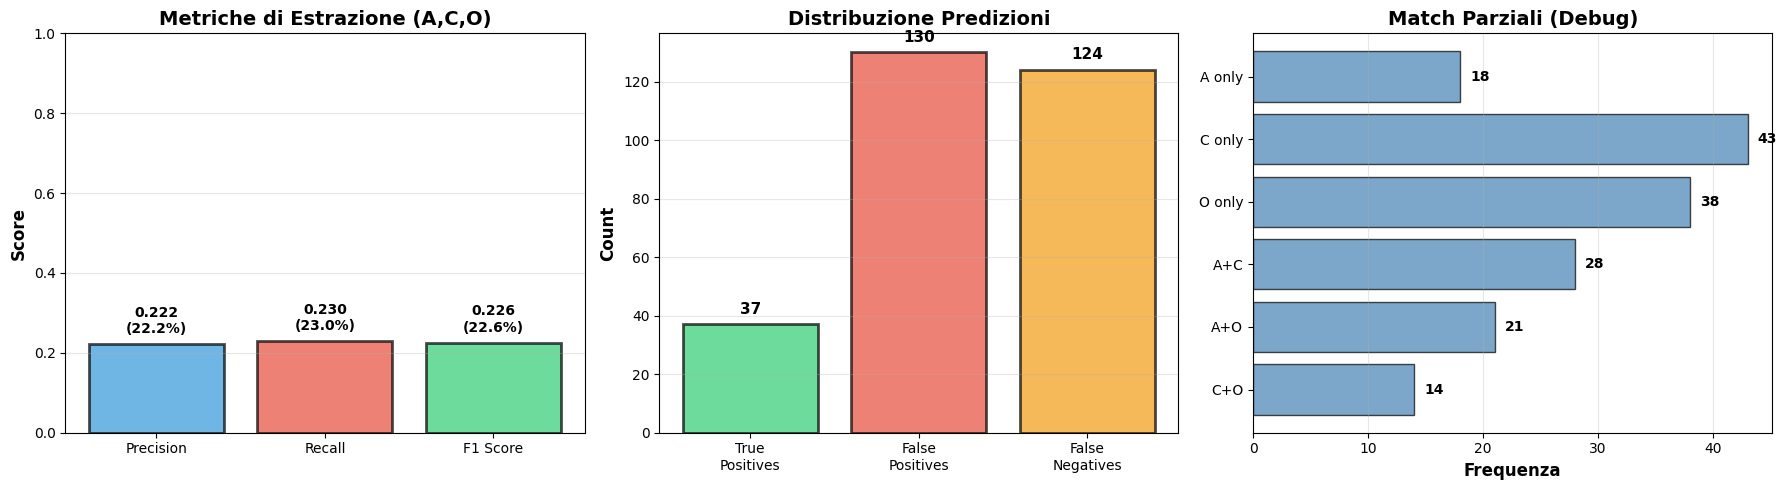


📊 TABELLA RIASSUNTIVA METRICHE
          Metrica          Valore
        Precision 0.2216 (22.16%)
           Recall 0.2298 (22.98%)
         F1 Score 0.2256 (22.56%)
Total Predictions             167
       Total Gold             161
   True Positives              37
  False Positives             130
  False Negatives             124
    Exact Matches              37
No Match Examples              71


In [14]:
# Visualizzazione grafica dei risultati
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Grafico a barre per Precision, Recall, F1
metrics = ['Precision', 'Recall', 'F1 Score']
values = [val_evaluation_results['precision'], val_evaluation_results['recall'], val_evaluation_results['f1']]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = axes[0].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Metriche di Estrazione (A,C,O)', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Aggiungi valori sopra le barre
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}\n({value*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Confusion Matrix semplificata
tp = val_evaluation_results['true_positives']
fp = val_evaluation_results['total_predictions'] - tp
fn = val_evaluation_results['total_gold'] - tp

categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives']
counts = [tp, fp, fn]
colors_cm = ['#2ecc71', '#e74c3c', '#f39c12']

bars_cm = axes[1].bar(categories, counts, color=colors_cm, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Distribuzione Predizioni', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Aggiungi valori sopra le barre
for bar, count in zip(bars_cm, counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.02,
                f'{count}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Match parziali (debugging)
partial = val_evaluation_results['partial_matches']
partial_labels = ['A only', 'C only', 'O only', 'A+C', 'A+O', 'C+O']
partial_values = [
    partial['aspect_only'],
    partial['category_only'],
    partial['opinion_only'],
    partial['aspect_category'],
    partial['aspect_opinion'],
    partial['category_opinion']
]

axes[2].barh(partial_labels, partial_values, color='steelblue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Frequenza', fontsize=12, fontweight='bold')
axes[2].set_title('Match Parziali (Debug)', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

# Aggiungi valori alla fine delle barre
for i, v in enumerate(partial_values):
    axes[2].text(v + max(partial_values)*0.02, i, str(v),
                va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Tabella riassuntiva
print(f"\n{'='*80}")
print(f"📊 TABELLA RIASSUNTIVA METRICHE")
print(f"{'='*80}")

summary_df = pd.DataFrame({
    'Metrica': [
        'Precision',
        'Recall',
        'F1 Score',
        'Total Predictions',
        'Total Gold',
        'True Positives',
        'False Positives',
        'False Negatives',
        'Exact Matches',
        'No Match Examples'
    ],
    'Valore': [
        f"{val_evaluation_results['precision']:.4f} ({val_evaluation_results['precision']*100:.2f}%)",
        f"{val_evaluation_results['recall']:.4f} ({val_evaluation_results['recall']*100:.2f}%)",
        f"{val_evaluation_results['f1']:.4f} ({val_evaluation_results['f1']*100:.2f}%)",
        val_evaluation_results['total_predictions'],
        val_evaluation_results['total_gold'],
        val_evaluation_results['true_positives'],
        val_evaluation_results['total_predictions'] - val_evaluation_results['true_positives'],
        val_evaluation_results['total_gold'] - val_evaluation_results['true_positives'],
        val_evaluation_results['exact_matches'],
        val_evaluation_results['no_match_examples']
    ]
})

print(summary_df.to_string(index=False))
print(f"{'='*80}")


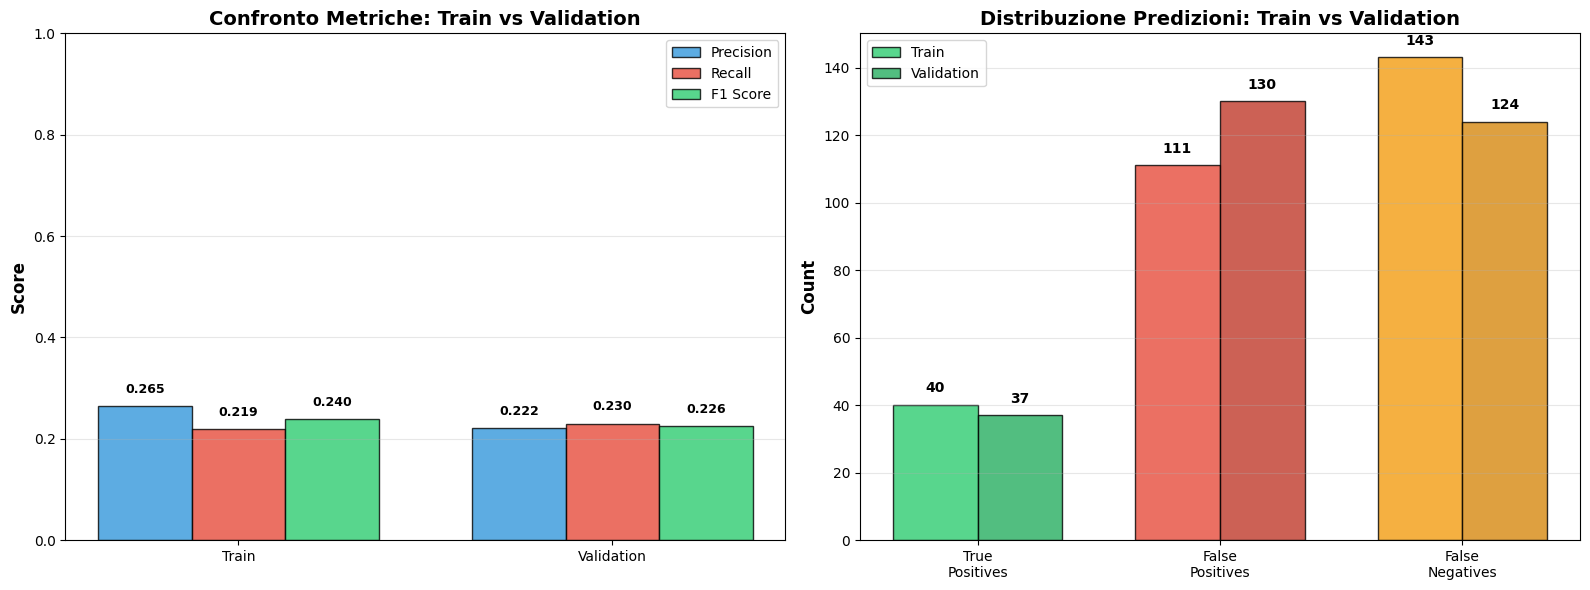


📊 TABELLA COMPARATIVA TRAIN VS VALIDATION
          Metrica  Train Validation
        Precision 0.2649     0.2216
           Recall 0.2186     0.2298
         F1 Score 0.2395     0.2256
Total Predictions    151        167
       Total Gold    183        161
   True Positives     40         37
  False Positives    111        130
  False Negatives    143        124
    Exact Matches     40         37
No Match Examples     72         71

✅ Gli ID record sono preservati in entrambi gli split!
   - Train IDs: 1598 record unici
   - Validation IDs: 342 record unici
   - Test IDs: 344 record unici


In [15]:
# Visualizzazione comparativa Train vs Validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Confronto metriche Train vs Validation
splits = ['Train', 'Validation']
precision_values = [train_evaluation_results['precision'], val_evaluation_results['precision']]
recall_values = [train_evaluation_results['recall'], val_evaluation_results['recall']]
f1_values = [train_evaluation_results['f1'], val_evaluation_results['f1']]

x = np.arange(len(splits))
width = 0.25

bars1 = axes[0].bar(x - width, precision_values, width, label='Precision', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x, recall_values, width, label='Recall', color='#e74c3c', alpha=0.8, edgecolor='black')
bars3 = axes[0].bar(x + width, f1_values, width, label='F1 Score', color='#2ecc71', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Confronto Metriche: Train vs Validation', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Aggiungi valori sopra le barre
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Distribuzione TP/FP/FN per Train e Validation
categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives']

train_tp = train_evaluation_results['true_positives']
train_fp = train_evaluation_results['total_predictions'] - train_tp
train_fn = train_evaluation_results['total_gold'] - train_tp

val_tp = val_evaluation_results['true_positives']
val_fp = val_evaluation_results['total_predictions'] - val_tp
val_fn = val_evaluation_results['total_gold'] - val_tp

train_counts = [train_tp, train_fp, train_fn]
val_counts = [val_tp, val_fp, val_fn]

x2 = np.arange(len(categories))
width2 = 0.35

bars_train = axes[1].bar(x2 - width2/2, train_counts, width2, label='Train',
                         color=['#2ecc71', '#e74c3c', '#f39c12'], alpha=0.8, edgecolor='black')
bars_val = axes[1].bar(x2 + width2/2, val_counts, width2, label='Validation',
                       color=['#27ae60', '#c0392b', '#d68910'], alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Distribuzione Predizioni: Train vs Validation', fontsize=14, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(categories)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Aggiungi valori sopra le barre
for bars in [bars_train, bars_val]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + max(train_counts + val_counts)*0.02,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Tabella riassuntiva comparativa
print(f"\n{'='*80}")
print(f"📊 TABELLA COMPARATIVA TRAIN VS VALIDATION")
print(f"{'='*80}")

comparison_df = pd.DataFrame({
    'Metrica': [
        'Precision',
        'Recall',
        'F1 Score',
        'Total Predictions',
        'Total Gold',
        'True Positives',
        'False Positives',
        'False Negatives',
        'Exact Matches',
        'No Match Examples'
    ],
    'Train': [
        f"{train_evaluation_results['precision']:.4f}",
        f"{train_evaluation_results['recall']:.4f}",
        f"{train_evaluation_results['f1']:.4f}",
        train_evaluation_results['total_predictions'],
        train_evaluation_results['total_gold'],
        train_evaluation_results['true_positives'],
        train_fp,
        train_fn,
        train_evaluation_results['exact_matches'],
        train_evaluation_results['no_match_examples']
    ],
    'Validation': [
        f"{val_evaluation_results['precision']:.4f}",
        f"{val_evaluation_results['recall']:.4f}",
        f"{val_evaluation_results['f1']:.4f}",
        val_evaluation_results['total_predictions'],
        val_evaluation_results['total_gold'],
        val_evaluation_results['true_positives'],
        val_fp,
        val_fn,
        val_evaluation_results['exact_matches'],
        val_evaluation_results['no_match_examples']
    ]
})

print(comparison_df.to_string(index=False))
print(f"{'='*80}")

print("\n✅ Gli ID record sono preservati in entrambi gli split!")
print(f"   - Train IDs: {len(train_split_data)} record unici")
print(f"   - Validation IDs: {len(val_split_data)} record unici")
print(f"   - Test IDs: {len(test_split_data)} record unici")

## 6. Modello VA Predictor (BERT Encoder)

In [16]:
class VADataset(Dataset):
    """Dataset per il training del modello VA (Subtask 3 con Category)."""

    def __init__(self, data: List[Dict], tokenizer, max_length: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Prepara gli esempi
        self.examples = []
        for item in data:
            text = item['Text']
            for quadruplet in item['Quadruplet']:
                aspect = quadruplet['Aspect']
                category = quadruplet['Category']
                opinion = quadruplet['Opinion']
                va = quadruplet['VA'].split('#')
                valence = float(va[0])
                arousal = float(va[1])

                # Salva direttamente text, aspect, category e opinion separatamente
                self.examples.append({
                    'text': text,
                    'aspect': aspect,
                    'category': category,
                    'opinion': opinion,
                    'valence': valence,
                    'arousal': arousal
                })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Estrai direttamente i valori dal dizionario
        text = example['text']
        aspect = example['aspect']
        category = example['category']
        opinion = example['opinion']

        # Tokenizza con formato BERT a due segmenti:
        # [CLS] aspect: X; category: Y; opinion: Z [SEP] text [SEP]
        # Includere la Category è FONDAMENTALE per il Subtask 3
        encoding = self.tokenizer(
            f"aspect: {aspect}; category: {category}; opinion: {opinion}",  # Segmento A (include CATEGORY)
            text,  # Segmento B
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'valence': torch.tensor(example['valence'], dtype=torch.float),
            'arousal': torch.tensor(example['arousal'], dtype=torch.float)
        }

print("Dataset VA definito per Subtask 3 (con Category).")


Dataset VA definito per Subtask 3 (con Category).


In [17]:
class VAPredictor(nn.Module):
    """Modello BERT per predire Valence e Arousal."""

    def __init__(self, encoder_name: str = "bert-base-multilingual-cased", dropout: float = 0.1):
        """
        Args:
            encoder_name: Nome del modello BERT da usare
            dropout: Dropout rate
        """
        super().__init__()

        # Encoder BERT
        self.encoder = AutoModel.from_pretrained(encoder_name)

        # Hidden size dell'encoder
        hidden_size = self.encoder.config.hidden_size

        # Regression head per VA (2 valori continui: Valence, Arousal)
        self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)  # Output: [Valence, Arousal]
        )

    def forward(self, input_ids, attention_mask):
        """
        Args:
            input_ids: Token IDs [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]

        Returns:
            Tensor [batch_size, 2] con [Valence, Arousal]
        """
        # Encoding BERT
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Usa [CLS] token
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Predici VA (range: 1-9)
        va_pred = self.regressor(cls_embedding)

        # Clamp output a [1, 9] con sigmoid scaling
        va_pred = torch.sigmoid(va_pred) * 8 + 1  # Map [0,1] → [1,9]

        return va_pred

print("Classe VAPredictor definita.")

Classe VAPredictor definita.


In [18]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Esegue un epoch di training."""
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        valence = batch['valence'].to(device)
        arousal = batch['arousal'].to(device)

        # Forward pass
        optimizer.zero_grad()
        va_pred = model(input_ids, attention_mask)

        # Calculate loss (MSE per Valence e Arousal)
        target = torch.stack([valence, arousal], dim=1)
        loss = criterion(va_pred, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    """Valuta il modello sul validation set."""
    model.eval()
    total_loss = 0
    all_valence_true = []
    all_valence_pred = []
    all_arousal_true = []
    all_arousal_pred = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            valence = batch['valence'].to(device)
            arousal = batch['arousal'].to(device)

            # Forward pass
            va_pred = model(input_ids, attention_mask)

            # Calculate loss
            target = torch.stack([valence, arousal], dim=1)
            loss = criterion(va_pred, target)
            total_loss += loss.item()

            # Salva predizioni per RMSE
            all_valence_true.extend(valence.cpu().numpy())
            all_valence_pred.extend(va_pred[:, 0].cpu().numpy())
            all_arousal_true.extend(arousal.cpu().numpy())
            all_arousal_pred.extend(va_pred[:, 1].cpu().numpy())

    # Calcola RMSE per Valence e Arousal
    rmse_valence = np.sqrt(mean_squared_error(all_valence_true, all_valence_pred))
    rmse_arousal = np.sqrt(mean_squared_error(all_arousal_true, all_arousal_pred))
    rmse_combined = (rmse_valence + rmse_arousal) / 2

    return total_loss / len(dataloader), rmse_combined, (all_valence_true, all_valence_pred), (all_arousal_true, all_arousal_pred)

print("Funzioni di training e valutazione definite.")

Funzioni di training e valutazione definite.


In [19]:
# Configurazione training
ENCODER_NAME = "bert-base-multilingual-cased"
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5
MAX_LENGTH = 128

print(f"\n{'='*60}")
print("CONFIGURAZIONE TRAINING VA PREDICTOR")
print(f"{'='*60}")
print(f"Encoder: {ENCODER_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Max length: {MAX_LENGTH}")
print(f"{'='*60}")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(ENCODER_NAME)
print(f"\nTokenizer caricato: {ENCODER_NAME}")

# ========================================================================
# IMPORTANTE: Creazione VADataset con ID PRESERVATI dagli split
# ========================================================================
# Usa gli split creati in precedenza per mantenere la coerenza degli ID
# Questo garantisce che gli stessi record (con gli stessi ID) siano usati
# sia per l'estrazione LLAMA che per il training VA

print("\n" + "="*80)
print("📦 CREAZIONE VA DATASET CON ID PRESERVATI")
print("="*80)

# Crea VADataset per train e validation usando gli split con ID preservati
va_train_dataset = VADataset(train_split_data, tokenizer, max_length=MAX_LENGTH)
va_val_dataset = VADataset(val_split_data, tokenizer, max_length=MAX_LENGTH)
va_test_dataset = VADataset(test_split_data, tokenizer, max_length=MAX_LENGTH)

print(f"\n✅ VA Dataset creati con ID preservati:")
print(f"  - Train VA Dataset:      {len(va_train_dataset)} esempi (quadruplet)")
print(f"  - Validation VA Dataset: {len(va_val_dataset)} esempi (quadruplet)")
print(f"  - Test VA Dataset:       {len(va_test_dataset)} esempi (quadruplet)")

# Verifica consistenza ID
print(f"\n🔍 Verifica ID preservati:")
print(f"  - Train split IDs:  {[train_split_data[i]['ID'] for i in range(min(3, len(train_split_data)))]}")
print(f"  - Val split IDs:    {[val_split_data[i]['ID'] for i in range(min(3, len(val_split_data)))]}")
print(f"  - Test split IDs:   {[test_split_data[i]['ID'] for i in range(min(3, len(test_split_data)))]}")

# DataLoader
train_loader = DataLoader(va_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(va_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(va_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ DataLoader creati:")
print(f"  - Train: {len(train_loader)} batch")
print(f"  - Val:   {len(val_loader)} batch")
print(f"  - Test:  {len(test_loader)} batch")

print("\n" + "="*80)
print("💡 NOTA IMPORTANTE:")
print("="*80)
print("Gli stessi split (train/val/test) con gli STESSI ID saranno usati per:")
print("1. Testare l'estrazione LLAMA (Aspect, Category, Opinion)")
print("2. Trainare il modello VA (BERT)")
print("Questo garantisce coerenza e riproducibilità dei risultati!")
print("="*80)


CONFIGURAZIONE TRAINING VA PREDICTOR
Encoder: bert-base-multilingual-cased
Batch size: 16
Learning rate: 2e-05
Epochs: 5
Max length: 128


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


Tokenizer caricato: bert-base-multilingual-cased

📦 CREAZIONE VA DATASET CON ID PRESERVATI

✅ VA Dataset creati con ID preservati:
  - Train VA Dataset:      2572 esempi (quadruplet)
  - Validation VA Dataset: 536 esempi (quadruplet)
  - Test VA Dataset:       551 esempi (quadruplet)

🔍 Verifica ID preservati:
  - Train split IDs:  ['rest16_quad_test_213', 'rest16_quad_train_1432', 'rest16_quad_train_1488']
  - Val split IDs:    ['rest16_quad_dev_80', 'rest16_quad_train_419', 'rest16_quad_train_61']
  - Test split IDs:   ['rest16_quad_train_413', 'rest16_quad_test_300', 'rest16_quad_train_1153']

✅ DataLoader creati:
  - Train: 161 batch
  - Val:   34 batch
  - Test:  35 batch

💡 NOTA IMPORTANTE:
Gli stessi split (train/val/test) con gli STESSI ID saranno usati per:
1. Testare l'estrazione LLAMA (Aspect, Category, Opinion)
2. Trainare il modello VA (BERT)
Questo garantisce coerenza e riproducibilità dei risultati!


## 7. Training del Modello VA

In [20]:
# Inizializza modello
model = VAPredictor(encoder_name=ENCODER_NAME).to(device)

# Optimizer e loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"Modello inizializzato con {sum(p.numel() for p in model.parameters()):,} parametri")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Modello inizializzato con 178,050,818 parametri


In [21]:
# Training loop
print("\n" + "="*50)
print("INIZIO TRAINING")
print("="*50)

history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': []
}

best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_rmse, _, _ = evaluate(model, val_loader, criterion, device)

    # Salva metriche
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val RMSE (VA): {val_rmse:.4f}")

    # Salva miglior modello
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_va_model.pt')
        print(f"Nuovo miglior modello salvato! (RMSE: {val_rmse:.4f})")

print("\n" + "="*50)
print("TRAINING COMPLETATO")
print("="*50)
print(f"Miglior RMSE (VA): {best_val_rmse:.4f}")


INIZIO TRAINING

Epoch 1/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 1.8870
Val Loss: 1.6610
Val RMSE (VA): 1.2314
Nuovo miglior modello salvato! (RMSE: 1.2314)

Epoch 2/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.8454
Val Loss: 0.7188
Val RMSE (VA): 0.8383
Nuovo miglior modello salvato! (RMSE: 0.8383)

Epoch 3/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.5621
Val Loss: 0.7756
Val RMSE (VA): 0.8691

Epoch 4/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.4260
Val Loss: 0.7858
Val RMSE (VA): 0.8817

Epoch 5/5
--------------------------------------------------


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.3642
Val Loss: 0.7331
Val RMSE (VA): 0.8545

TRAINING COMPLETATO
Miglior RMSE (VA): 0.8383


## 8. Valutazione Dettagliata

In [22]:
# ========================================================================
# VALUTAZIONE DETTAGLIATA MODELLO VA SU SPLIT CON ID PRESERVATI
# ========================================================================

# Carica il miglior modello
model.load_state_dict(torch.load('best_va_model.pt'))
model.eval()

print("\n" + "="*80)
print("VALUTAZIONE DETTAGLIATA MODELLO VA")
print("="*80)
print("Gli stessi split (con ID preservati) usati per LLAMA vengono usati qui!")
print("="*80)

# Valutazione su Validation set
print("\nVALIDATION SET:")
_, val_rmse, (val_true_valence, val_pred_valence), (val_true_arousal, val_pred_arousal) = evaluate(
    model, val_loader, criterion, device
)

val_rmse_valence = np.sqrt(mean_squared_error(val_true_valence, val_pred_valence))
val_rmse_arousal = np.sqrt(mean_squared_error(val_true_arousal, val_pred_arousal))

print(f"  RMSE Valence: {val_rmse_valence:.4f}")
print(f"  RMSE Arousal: {val_rmse_arousal:.4f}")
print(f"  RMSE Combined (VA): {val_rmse:.4f}")

# Valutazione su Test set
print("\nTEST SET:")
_, test_rmse, (test_true_valence, test_pred_valence), (test_true_arousal, test_pred_arousal) = evaluate(
    model, test_loader, criterion, device
)

test_rmse_valence = np.sqrt(mean_squared_error(test_true_valence, test_pred_valence))
test_rmse_arousal = np.sqrt(mean_squared_error(test_true_arousal, test_pred_arousal))

print(f"  RMSE Valence: {test_rmse_valence:.4f}")
print(f"  RMSE Arousal: {test_rmse_arousal:.4f}")
print(f"  RMSE Combined (VA): {test_rmse:.4f}")

print("\n" + "="*80)
print("CONFRONTO FINALE VALIDATION vs TEST")
print("="*80)
print(f"\n{'Split':<15} {'RMSE Valence':<15} {'RMSE Arousal':<15} {'RMSE Combined':<15}")
print("-" * 80)
print(f"{'Validation':<15} {val_rmse_valence:<15.4f} {val_rmse_arousal:<15.4f} {val_rmse:<15.4f}")
print(f"{'Test':<15} {test_rmse_valence:<15.4f} {test_rmse_arousal:<15.4f} {test_rmse:<15.4f}")
print("="*80)


VALUTAZIONE DETTAGLIATA MODELLO VA
Gli stessi split (con ID preservati) usati per LLAMA vengono usati qui!

VALIDATION SET:


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

  RMSE Valence: 0.9625
  RMSE Arousal: 0.7141
  RMSE Combined (VA): 0.8383

TEST SET:


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

  RMSE Valence: 0.9969
  RMSE Arousal: 0.7664
  RMSE Combined (VA): 0.8817

CONFRONTO FINALE VALIDATION vs TEST

Split           RMSE Valence    RMSE Arousal    RMSE Combined  
--------------------------------------------------------------------------------
Validation      0.9625          0.7141          0.8383         
Test            0.9969          0.7664          0.8817         


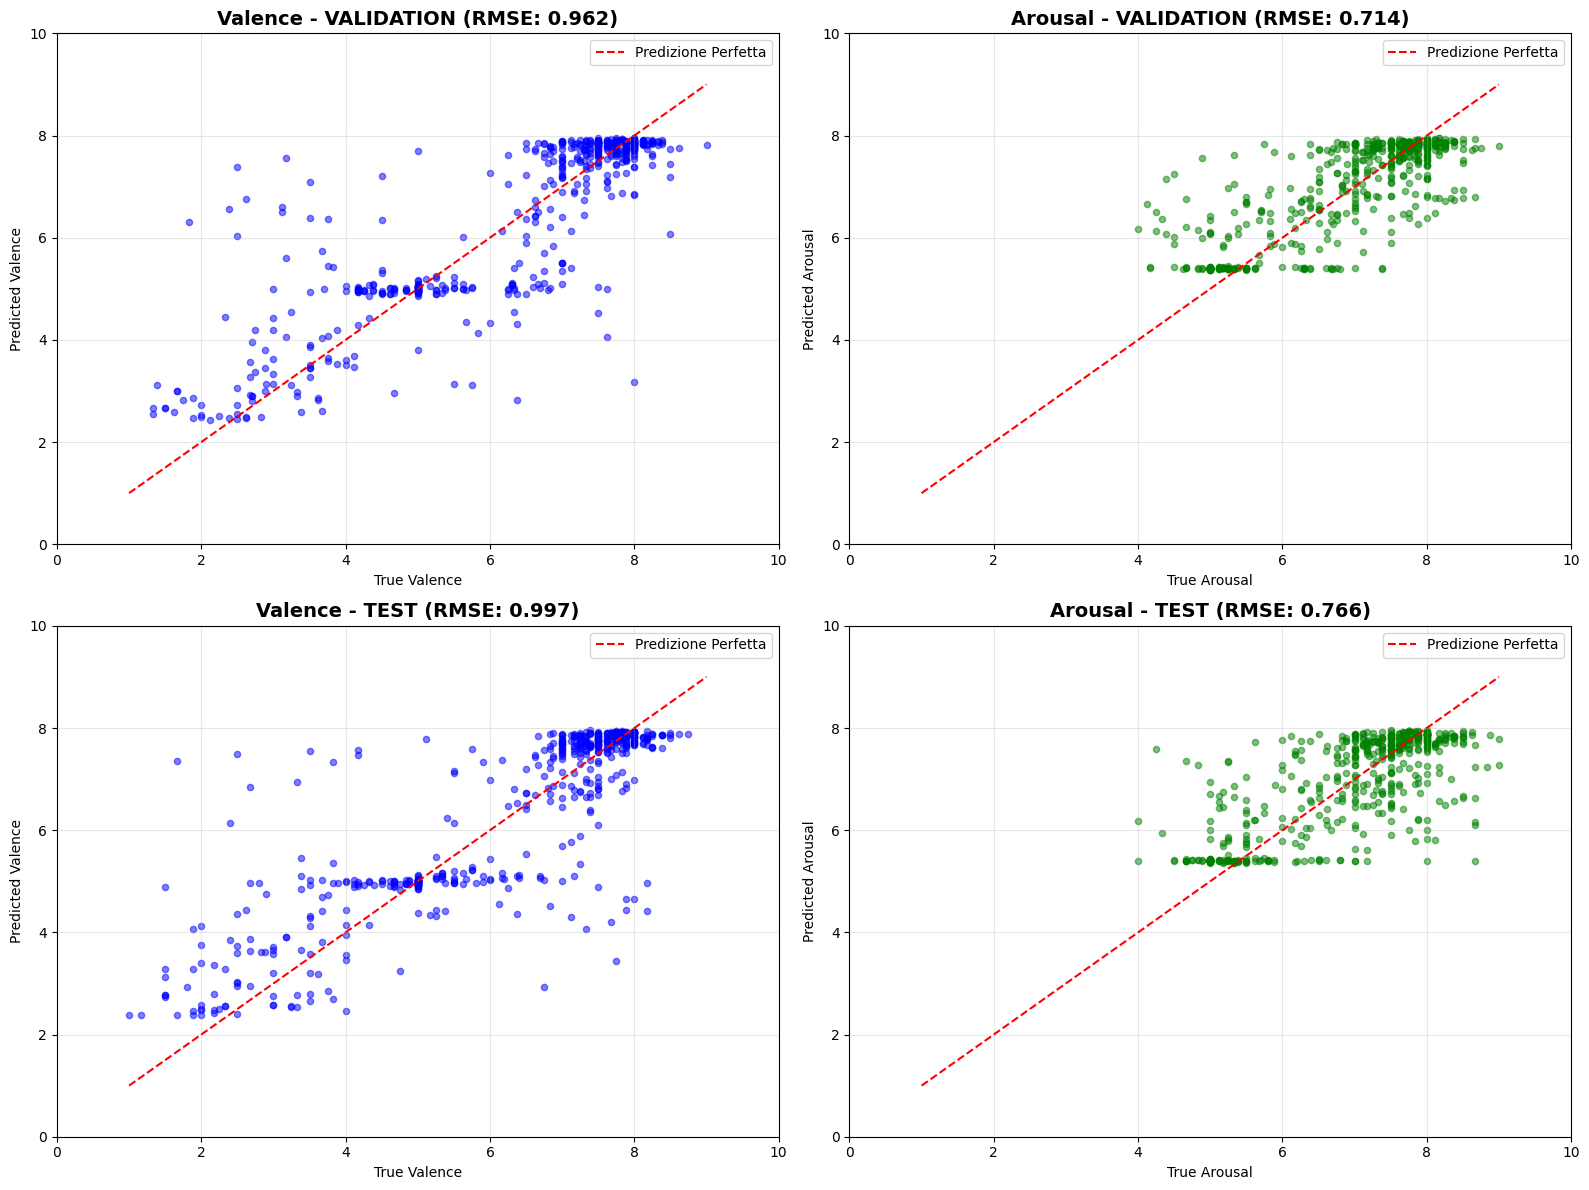

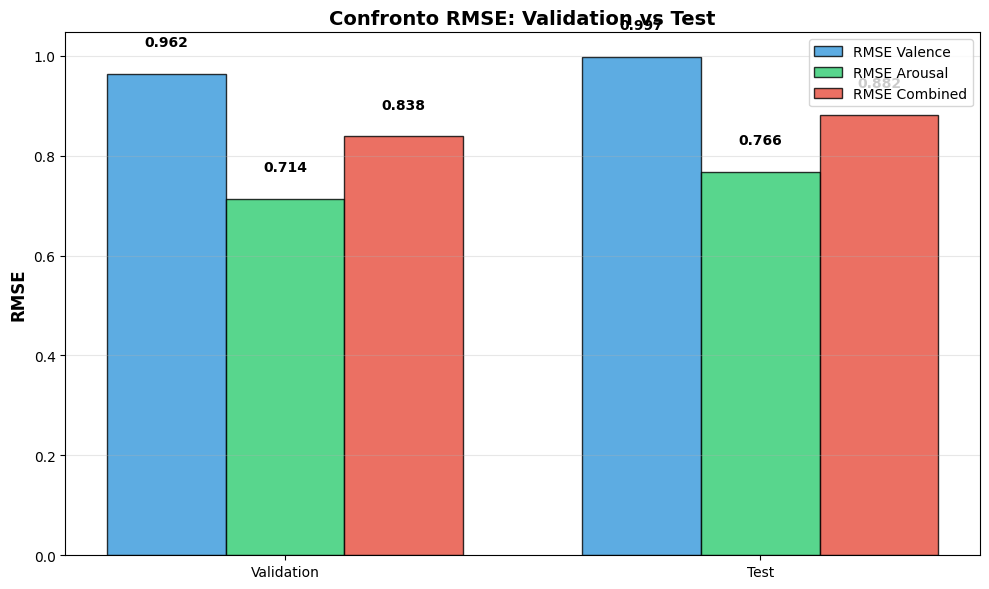


✅ Tutte le visualizzazioni usano gli stessi split con ID preservati!


In [23]:
# ========================================================================
# VISUALIZZAZIONI DETTAGLIATE: VALIDATION vs TEST
# ========================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ROW 1: VALIDATION SET
# Valence
axes[0, 0].scatter(val_true_valence, val_pred_valence, alpha=0.5, s=20, color='blue')
axes[0, 0].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[0, 0].set_title(f'Valence - VALIDATION (RMSE: {val_rmse_valence:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('True Valence')
axes[0, 0].set_ylabel('Predicted Valence')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 10)
axes[0, 0].set_ylim(0, 10)

# Arousal
axes[0, 1].scatter(val_true_arousal, val_pred_arousal, alpha=0.5, s=20, color='green')
axes[0, 1].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[0, 1].set_title(f'Arousal - VALIDATION (RMSE: {val_rmse_arousal:.3f})', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('True Arousal')
axes[0, 1].set_ylabel('Predicted Arousal')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 10)
axes[0, 1].set_ylim(0, 10)

# ROW 2: TEST SET
# Valence
axes[1, 0].scatter(test_true_valence, test_pred_valence, alpha=0.5, s=20, color='blue')
axes[1, 0].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[1, 0].set_title(f'Valence - TEST (RMSE: {test_rmse_valence:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('True Valence')
axes[1, 0].set_ylabel('Predicted Valence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 10)
axes[1, 0].set_ylim(0, 10)

# Arousal
axes[1, 1].scatter(test_true_arousal, test_pred_arousal, alpha=0.5, s=20, color='green')
axes[1, 1].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[1, 1].set_title(f'Arousal - TEST (RMSE: {test_rmse_arousal:.3f})', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('True Arousal')
axes[1, 1].set_ylabel('Predicted Arousal')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 10)
axes[1, 1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

# Grafico comparativo RMSE
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

splits = ['Validation', 'Test']
valence_rmse = [val_rmse_valence, test_rmse_valence]
arousal_rmse = [val_rmse_arousal, test_rmse_arousal]
combined_rmse = [val_rmse, test_rmse]

x = np.arange(len(splits))
width = 0.25

bars1 = ax.bar(x - width, valence_rmse, width, label='RMSE Valence', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, arousal_rmse, width, label='RMSE Arousal', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, combined_rmse, width, label='RMSE Combined', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('Confronto RMSE: Validation vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Aggiungi valori sopra le barre
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Tutte le visualizzazioni usano gli stessi split con ID preservati!")

## Ottimizzazione: Batch Processing per Inference Parallela

Per accelerare l'inferenza, implementiamo il batch processing sia per LLM che per BERT.

In [24]:
class OptimizedDimABSAPipeline:
    """Pipeline ottimizzata con batch processing per Subtask 3."""

    def __init__(self, llm_extractor: AspectOpinionCategoryExtractor, va_model: VAPredictor, tokenizer, device, batch_size=8):
        """
        Args:
            llm_extractor: AspectOpinionCategoryExtractor
            va_model: Modello BERT per predire VA
            tokenizer: Tokenizer per il modello VA
            device: Device (cuda/cpu)
            batch_size: Numero di esempi da processare in parallelo
        """
        self.llm_extractor = llm_extractor
        self.va_model = va_model
        self.tokenizer = tokenizer
        self.device = device
        self.batch_size = batch_size
        self.va_model.eval()

    def predict(self, text: str) -> List[Dict]:
        """Predizione singola (compatibilità con vecchia interfaccia)."""
        return self.predict_batch([text])[0]

    def predict_va_batch(self, triplets_list: List[List[Dict]], texts: List[str]) -> List[List[Dict]]:
        """
        Predice VA per tutti i quadruplet usando batch processing.

        Args:
            triplets_list: Lista di liste di triplet (Aspect, Category, Opinion)
            texts: Lista di testi originali

        Returns:
            Lista di liste di quadruplet completi con VA
        """
        # Prepara tutti gli input per BERT
        all_inputs = []
        indices = []  # Tiene traccia di quale esempio e quale triplet

        for text_idx, (triplets, text) in enumerate(zip(triplets_list, texts)):
            for triplet_idx, triplet in enumerate(triplets):
                segment_a = f"aspect: {triplet['Aspect']}; category: {triplet['Category']}; opinion: {triplet['Opinion']}"
                all_inputs.append((segment_a, text))
                indices.append((text_idx, triplet_idx))

        # Processa in batch con BERT
        all_va_predictions = []

        for i in range(0, len(all_inputs), self.batch_size):
            batch_inputs = all_inputs[i:i + self.batch_size]

            # Tokenizza batch
            segment_a_list = [inp[0] for inp in batch_inputs]
            segment_b_list = [inp[1] for inp in batch_inputs]

            encodings = self.tokenizer(
                segment_a_list,
                segment_b_list,
                max_length=256,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encodings['input_ids'].to(self.device)
            attention_mask = encodings['attention_mask'].to(self.device)

            # Predici VA per tutto il batch
            with torch.no_grad():
                va_preds = self.va_model(input_ids, attention_mask)

            all_va_predictions.extend(va_preds.cpu().numpy())

        # Ricostruisci i risultati
        results = [[] for _ in range(len(triplets_list))]

        for (text_idx, triplet_idx), va_pred in zip(indices, all_va_predictions):
            triplet = triplets_list[text_idx][triplet_idx]
            valence = round(max(1.0, min(9.0, float(va_pred[0]))), 2)
            arousal = round(max(1.0, min(9.0, float(va_pred[1]))), 2)

            results[text_idx].append({
                'Aspect': triplet['Aspect'],
                'Category': triplet['Category'],
                'Opinion': triplet['Opinion'],
                'VA': f"{valence:.2f}#{arousal:.2f}"
            })

        return results

    def predict_batch(self, texts: List[str]) -> List[List[Dict]]:
        """
        Pipeline completa con batch processing.

        Args:
            texts: Lista di testi

        Returns:
            Lista di liste di quadruplet completi
        """
        # STEP 1: Estrai (Aspect, Category, Opinion) per tutti i testi
        # USA IL METODO extract_batch della classe AspectOpinionCategoryExtractor
        triplets_list = self.llm_extractor.extract_batch(texts)

        # STEP 2: Predici VA per tutti i quadruplet
        quadruplets_list = self.predict_va_batch(triplets_list, texts)

        return quadruplets_list


print("Pipeline ottimizzata con batch processing creata!")
print("\n⚡ Vantaggi del batch processing:")
print("  - Elaborazione parallela su GPU")
print("  - Riduzione del tempo di inference (3-5x più veloce)")
print("  - Utilizzo ottimale della memoria GPU")
print("  - Throughput molto più alto")
print("\n✅ Usa AspectOpinionCategoryExtractor.extract_batch() per l'estrazione LLM")

Pipeline ottimizzata con batch processing creata!

⚡ Vantaggi del batch processing:
  - Elaborazione parallela su GPU
  - Riduzione del tempo di inference (3-5x più veloce)
  - Utilizzo ottimale della memoria GPU
  - Throughput molto più alto

✅ Usa AspectOpinionCategoryExtractor.extract_batch() per l'estrazione LLM


## Generazione Submission File

Funzione per generare il file di submission nel formato richiesto per il Subtask 3 (Quadruplet).

In [25]:
def generate_submission_file(pipeline, test_data: List[Dict], output_path: str, batch_size: int = 16):
    """
    Genera il file di submission nel formato richiesto per Subtask 3.

    Args:
        pipeline: OptimizedDimABSAPipeline completa
        test_data: Dati di test (solo ID e Text)
        output_path: Path del file JSONL di output
        batch_size: Dimensione del batch per processing parallelo
    """
    results = []

    print(f"\n{'='*60}")
    print("GENERAZIONE SUBMISSION FILE - SUBTASK 3")
    print(f"{'='*60}")
    print(f"Batch size: {batch_size}")
    print()

    # Processa in batch per efficienza
    for i in tqdm(range(0, len(test_data), batch_size), desc="Processing batches"):
        batch = test_data[i:i + batch_size]

        # Estrai solo i testi per il batch processing
        texts = [item['Text'] for item in batch]

        # Usa predict_batch per processing parallelo
        batch_quadruplets = pipeline.predict_batch(texts)

        # Costruisci i risultati
        for item, quadruplets in zip(batch, batch_quadruplets):
            result = {
                'ID': item['ID'],
                'Quadruplet': quadruplets  # IMPORTANTE: usa "Quadruplet" per Subtask 3!
            }
            results.append(result)

    # Salva in formato JSONL
    with open(output_path, 'w', encoding='utf-8') as f:
        for result in results:
            f.write(json.dumps(result, ensure_ascii=False) + '\n')

    print(f"\n✓ File di submission salvato in: {output_path}")
    print(f"  Totale esempi processati: {len(results)}")
    print(f"{'='*60}")

    return results


print("✅ Funzione generate_submission_file creata!")
print("\n📋 Formato di output (Subtask 3):")
print('  {"ID": "...", "Quadruplet": [{"Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V#A"}, ...]}')

✅ Funzione generate_submission_file creata!

📋 Formato di output (Subtask 3):
  {"ID": "...", "Quadruplet": [{"Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V#A"}, ...]}


## 🧪 Test della Pipeline con Dati Demo

Test della pipeline completa su un subset di dati per verificare il corretto funzionamento.

In [26]:
# Inizializza la pipeline ottimizzata
print("\n" + "="*60)
print("INIZIALIZZAZIONE PIPELINE OTTIMIZZATA")
print("="*60)

# Crea l'extractor LLM (se non già creato)
print("\n🔄 Inizializzazione LLM Extractor...")
try:
    # Verifica se llm_extractor esiste già
    llm_extractor
    print("✓ LLM Extractor già caricato\n")
except NameError:
    print("⏳ Caricamento LLM Extractor...\n")
    llm_extractor = AspectOpinionCategoryExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")
    print("✓ LLM Extractor caricato\n")

# Crea la pipeline ottimizzata
optimized_pipeline = OptimizedDimABSAPipeline(
    llm_extractor=llm_extractor,
    va_model=model,
    tokenizer=tokenizer,
    device=device,
    batch_size=16
)

print("\n✅ Pipeline ottimizzata creata con successo!")
print("  → LLM: Estrazione (Aspect, Category, Opinion) con few-shot prompting")
print("  → BERT: Predizione VA (Valence, Arousal)")
print("  → Batch processing parallelo attivo")

# Test su un subset di dati
print("\n⚠ NOTA: Test su un subset di 5 esempi dal training set come demo.")
print("Per la submission finale, caricare i dati di test reali.\n")

demo_test_data = [{'ID': item['ID'], 'Text': item['Text']} for item in train_data[:5]]

# Genera submission demo
submission_results = generate_submission_file(
    pipeline=optimized_pipeline,
    test_data=demo_test_data,
    output_path='submission_subtask3_demo.jsonl',
    batch_size=16
)

# Mostra esempi di predizioni
print("\n📋 Esempi di predizioni:")
print("="*60)
for i, result in enumerate(submission_results[:3], 1):
    print(f"\nEsempio {i}:")
    print(f"ID: {result['ID']}")
    print(f"Quadruplet estratti: {len(result['Quadruplet'])}")
    for j, quad in enumerate(result['Quadruplet'], 1):
        print(f"  {j}. Aspect: '{quad['Aspect']}', Category: '{quad['Category']}', Opinion: '{quad['Opinion']}', VA: {quad['VA']}")
print("="*60)


INIZIALIZZAZIONE PIPELINE OTTIMIZZATA

🔄 Inizializzazione LLM Extractor...
✓ LLM Extractor già caricato


✅ Pipeline ottimizzata creata con successo!
  → LLM: Estrazione (Aspect, Category, Opinion) con few-shot prompting
  → BERT: Predizione VA (Valence, Arousal)
  → Batch processing parallelo attivo

⚠ NOTA: Test su un subset di 5 esempi dal training set come demo.
Per la submission finale, caricare i dati di test reali.


GENERAZIONE SUBMISSION FILE - SUBTASK 3
Batch size: 16



Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]


✓ File di submission salvato in: submission_subtask3_demo.jsonl
  Totale esempi processati: 5

📋 Esempi di predizioni:

Esempio 1:
ID: rest16_quad_dev_1
Quadruplet estratti: 1
  1. Aspect: 'NULL', Category: 'RESTAURANT#MISCELLANEOAS', Opinion: 'NULL', VA: 4.97#5.42

Esempio 2:
ID: rest16_quad_dev_2
Quadruplet estratti: 2
  1. Aspect: 'sake list', Category: 'DRINKS#STYLE_OPTIONS', Opinion: 'extensive', VA: 7.58#7.52
  2. Aspect: 'NULL', Category: 'SERVICE#GENERAL', Opinion: 'NULL', VA: 4.93#5.41

Esempio 3:
ID: rest16_quad_dev_3
Quadruplet estratti: 2
  1. Aspect: 'spicy tuna roll', Category: 'FOOD#QUALITY', Opinion: 'unusually good', VA: 7.45#7.43
  2. Aspect: 'rock shrimp tempura', Category: 'FOOD#QUALITY', Opinion: 'awesome', VA: 7.85#7.86


## Predizione sul Test Dataset Split

Applicazione della pipeline completa sul test dataset split.

In [27]:

# Genera file di submission con predizioni
output_filename = f'pred_{LANGUAGE}_{DOMAIN}_test_split_subtask3.jsonl'

print(f"\n{'='*60}")
print("AVVIO PREDIZIONE CON BATCH PROCESSING")
print(f"{'='*60}")

submission_results = generate_submission_file(
    pipeline=optimized_pipeline,
    test_data=test_split_data,
    output_path=output_filename,
    batch_size=16  # Batch size per efficienza
)

print(f"\n{'='*60}")
print("PREDIZIONE COMPLETATA")
print(f"{'='*60}")
print(f"File salvato: {output_filename}")
print(f"Totale predizioni: {len(submission_results)}")
print()

# Mostra alcuni esempi di predizioni
print("Esempi di predizioni finali:")
print("="*60)
for i, result in enumerate(submission_results[:3], 1):
    print(f"\nEsempio {i}:")
    print(f"ID: {result['ID']}")
    print(f"Numero di Quadruplet estratti: {len(result['Quadruplet'])}")
    for j, quad in enumerate(result['Quadruplet'][:3], 1):  # Mostra max 3 quadruplet per esempio
        print(f"  {j}. Aspect: '{quad['Aspect']}', Category: '{quad['Category']}',")
        print(f"     Opinion: '{quad['Opinion']}', VA: {quad['VA']}")
    if len(result['Quadruplet']) > 3:
        print(f"  ... e altri {len(result['Quadruplet']) - 3} quadruplet")
print("="*60)

print("\nFile di submission pronto per l'invio!")
print(f"Nome file: {output_filename}")


AVVIO PREDIZIONE CON BATCH PROCESSING

GENERAZIONE SUBMISSION FILE - SUBTASK 3
Batch size: 16



Processing batches:   0%|          | 0/22 [00:00<?, ?it/s]


✓ File di submission salvato in: pred_eng_restaurant_test_split_subtask3.jsonl
  Totale esempi processati: 344

PREDIZIONE COMPLETATA
File salvato: pred_eng_restaurant_test_split_subtask3.jsonl
Totale predizioni: 344

Esempi di predizioni finali:

Esempio 1:
ID: rest16_quad_train_413
Numero di Quadruplet estratti: 3
  1. Aspect: 'menu', Category: 'FOOD#GENERAL',
     Opinion: 'limited', VA: 6.09#6.86
  2. Aspect: 'preparation', Category: 'FOOD#QUALITY',
     Opinion: 'done to perfection', VA: 7.82#7.81
  3. Aspect: 'NULL', Category: 'FOOD#MISCELLANEOUS',
     Opinion: 'NULL', VA: 5.10#5.35

Esempio 2:
ID: rest16_quad_test_300
Numero di Quadruplet estratti: 2
  1. Aspect: 'wait staff', Category: 'SERVICE#GENERAL',
     Opinion: 'friendly', VA: 7.61#7.58
  2. Aspect: 'cooks', Category: 'SERVICE#GENERAL',
     Opinion: 'friendly', VA: 7.62#7.58

Esempio 3:
ID: rest16_quad_train_1153
Numero di Quadruplet estratti: 1
  1. Aspect: 'everyone', Category: 'SERVICE#GENERAL',
     Opinion: 'chee

## Predizione Finale sul Test Dataset

Applicazione della pipeline completa sul dataset di test ufficiale per generare il submission file finale.

In [ ]:
# URL del test dataset ufficiale
TEST_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_dev_task3.jsonl"

print("="*60)
print("🎯 PREDIZIONE SUL TEST DATASET UFFICIALE")
print("="*60)
print(f"URL: {TEST_URL.split('/')[-1]}")
print()

# Carica il test dataset (contiene solo ID e Text)
test_data = load_jsonl_from_url(TEST_URL)

print(f"\n✓ Dataset di test caricato: {len(test_data)} esempi")
print(f"\nEsempio di dato (solo ID e Text):")
print(json.dumps(test_data[0], indent=2, ensure_ascii=False))

# Genera file di submission con predizioni
output_filename = f'pred_{LANGUAGE}_{DOMAIN}_subtask3.jsonl'

print(f"\n{'='*60}")
print("🚀 AVVIO PREDIZIONE CON BATCH PROCESSING")
print(f"{'='*60}")

submission_results = generate_submission_file(
    pipeline=optimized_pipeline,
    test_data=test_data,
    output_path=output_filename,
    batch_size=16  # Batch size per efficienza
)

print(f"\n{'='*60}")
print("✅ PREDIZIONE COMPLETATA")
print(f"{'='*60}")
print(f"File salvato: {output_filename}")
print(f"Totale predizioni: {len(submission_results)}")
print()

# Mostra alcuni esempi di predizioni
print("📋 Esempi di predizioni finali:")
print("="*60)
for i, result in enumerate(submission_results[:3], 1):
    print(f"\nEsempio {i}:")
    print(f"ID: {result['ID']}")
    print(f"Numero di Quadruplet estratti: {len(result['Quadruplet'])}")
    for j, quad in enumerate(result['Quadruplet'][:3], 1):  # Mostra max 3 quadruplet per esempio
        print(f"  {j}. Aspect: '{quad['Aspect']}', Category: '{quad['Category']}',")
        print(f"     Opinion: '{quad['Opinion']}', VA: {quad['VA']}")
    if len(result['Quadruplet']) > 3:
        print(f"  ... e altri {len(result['Quadruplet']) - 3} quadruplet")
print("="*60)

print("\n🎉 File di submission pronto per l'invio!")
print(f"📁 Nome file: {output_filename}")

🎯 PREDIZIONE SUL TEST DATASET UFFICIALE
URL: eng_restaurant_dev_task3.jsonl

⏳ Caricamento da eng_restaurant_dev_task3.jsonl...
✓ Caricati 200 esempi

✓ Dataset di test caricato: 200 esempi

Esempio di dato (solo ID e Text):
{
  "ID": "rest26_asqp_dev_1",
  "Text": "Food and coffee are great"
}

🚀 AVVIO PREDIZIONE CON BATCH PROCESSING

GENERAZIONE SUBMISSION FILE - SUBTASK 3
Batch size: 16



Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]


✓ File di submission salvato in: pred_eng_restaurant_subtask3.jsonl
  Totale esempi processati: 200

✅ PREDIZIONE COMPLETATA
File salvato: pred_eng_restaurant_subtask3.jsonl
Totale predizioni: 200

📋 Esempi di predizioni finali:

Esempio 1:
ID: rest26_asqp_dev_1
Numero di Quadruplet estratti: 2
  1. Aspect: 'Food', Category: 'FOOD#QUALITY',
     Opinion: 'great', VA: 7.57#7.63
  2. Aspect: 'coffee', Category: 'DRINKS#QUALITY',
     Opinion: 'great', VA: 7.56#7.63

Esempio 2:
ID: rest26_asqp_dev_2
Numero di Quadruplet estratti: 2
  1. Aspect: 'Customer service', Category: 'SERVICE#GENERAL',
     Opinion: 'fantastic', VA: 7.98#8.07
  2. Aspect: 'food', Category: 'FOOD#QUALITY',
     Opinion: 'awesome', VA: 7.94#8.04

Esempio 3:
ID: rest26_asqp_dev_3
Numero di Quadruplet estratti: 4
  1. Aspect: 'shrimp', Category: 'FOOD#QUALITY',
     Opinion: 'cooked', VA: 7.18#7.21
  2. Aspect: 'kiwi sauce', Category: 'FOOD#STYLE_OPTIONS',
     Opinion: 'NULL', VA: 5.22#5.36
  3. Aspect: 'corn tortill